## Model using LightGBM classifier 

* Single model for home credit default risk.
* Create features from main application table.
* Create features from supplementary tables (prev/bureau/installment/pos-cash/credit card), groupy by current ID and merge to main table.
* Read preprocessed features generated from other notebooks and merge to main table.
* Fit LGBMClassifier and save results to disk for ensembling.


~~ Public LB: 0.8050 

In [6]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

from lightgbm import LGBMClassifier, LGBMRegressor
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import os
print(os.listdir('C:/Users/monis/Desktop/home-credit-default-risk-master/home-credit-default-risk-master'))
    
gc.enable()

['.gitignore', 'input', 'notebooks', 'output', 'README.md']


#### Define utility functions
* downcast_type to save memory space
* mean_encoding for categorical features. Use KFold regularization to avoid leak.

In [7]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype in ["int64"]]

    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)

    return df

def mean_encode(train, val, features_to_encode, target, drop=False):
    train_encode = train.copy(deep=True)
    val_encode = val.copy(deep=True)
    for feature in features_to_encode:
        train_global_mean = train[target].mean()
        train_encode_map = pd.DataFrame(index = train[feature].unique())
        train_encode[feature+'_mean_encode'] = np.nan
        kf = KFold(n_splits=5, shuffle=False)
        for rest, this in kf.split(train):
            train_rest_global_mean = train[target].iloc[rest].mean()
            encode_map = train.iloc[rest].groupby(feature)[target].mean()
            encoded_feature = train.iloc[this][feature].map(encode_map).values
            train_encode[feature+'_mean_encode'].iloc[this] = train[feature].iloc[this].map(encode_map).values
            train_encode_map = pd.concat((train_encode_map, encode_map), axis=1, sort=False)
            train_encode_map.fillna(train_rest_global_mean, inplace=True) 
            train_encode[feature+'_mean_encode'].fillna(train_rest_global_mean, inplace=True)
            
        train_encode_map['avg'] = train_encode_map.mean(axis=1)
        val_encode[feature+'_mean_encode'] = val[feature].map(train_encode_map['avg'])
        val_encode[feature+'_mean_encode'].fillna(train_global_mean,inplace=True)
        
    if drop: #drop unencoded features
        train_encode.drop(features_to_encode, axis=1, inplace=True)
        val_encode.drop(features_to_encode, axis=1, inplace=True)
    return train_encode, val_encode

#### Main application table

In [9]:
#list for mean encoding features and categorical features
meanenc_feats = []
cat_feats = []

data = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')
y = data['TARGET']
#####process train and test together######
combined = data.append(test,sort=False)
train_size = data.shape[0]
test_size = test.shape[0]

combined['CODE_GENDER'].replace('XNA', np.nan, inplace=True)
combined['NAME_FAMILY_STATUS'].replace('Unknown', np.nan, inplace=True)
combined['ORGANIZATION_TYPE'].replace('XNA', np.nan, inplace=True)
combined['DAYS_EMPLOYED'].loc[combined['DAYS_EMPLOYED']==365243] = np.nan
#create some new features
#from https://www.kaggle.com/poohtls/fork-of-fork-lightgbm-with-simple-features/code
docs = [f_ for f_ in combined.columns if 'FLAG_DOC' in f_]
live = [f_ for f_ in combined.columns if ('FLAG_' in f_) & ('FLAG_DOC' not in f_) & ('_FLAG_' not in f_)]
combined['NEW_DOC_IND_KURT'] = combined[docs].kurtosis(axis=1)
combined['NEW_LIVE_IND_SUM'] = combined[live].sum(axis=1)
combined['NEW_INC_PER_CHLD'] = combined['AMT_INCOME_TOTAL'] / (1 + combined['CNT_CHILDREN'])
inc_by_org = combined[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']
combined['NEW_INC_BY_ORG'] = combined['ORGANIZATION_TYPE'].map(inc_by_org)
combined['NEW_EMPLOY_TO_BIRTH_RATIO'] = combined['DAYS_EMPLOYED'] / combined['DAYS_BIRTH']
combined['NEW_SOURCES_PROD'] = combined['EXT_SOURCE_1'] * combined['EXT_SOURCE_2'] * combined['EXT_SOURCE_3']
combined['NEW_EXT_SOURCES_MEAN'] = combined[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
combined['NEW_SCORES_STD'] = combined[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
combined['NEW_SCORES_STD'] = combined['NEW_SCORES_STD'].fillna(combined['NEW_SCORES_STD'].mean())
combined['NEW_CAR_TO_BIRTH_RATIO'] = combined['OWN_CAR_AGE'] / combined['DAYS_BIRTH']
combined['NEW_CAR_TO_EMPLOY_RATIO'] = combined['OWN_CAR_AGE'] / combined['DAYS_EMPLOYED']
combined['NEW_PHONE_TO_BIRTH_RATIO'] = combined['DAYS_LAST_PHONE_CHANGE'] / combined['DAYS_BIRTH']
combined['NEW_PHONE_TO_EMPLOYED_RATIO'] = combined['DAYS_LAST_PHONE_CHANGE'] / combined['DAYS_EMPLOYED']
combined['NEW_CREDIT_TO_INCOME_RATIO'] = combined['AMT_CREDIT'] / combined['AMT_INCOME_TOTAL']

combined['AMT_PAY_YEAR'] = combined['AMT_CREDIT']/combined['AMT_ANNUITY']
combined['AGE_PAYOFF'] = -combined['DAYS_BIRTH']/365.25 + combined['AMT_PAY_YEAR']
combined['AMT_ANNUITY_INCOME_RATE'] = combined['AMT_ANNUITY']/combined['AMT_INCOME_TOTAL']
combined['AMT_DIFF_CREDIT_GOODS'] = combined['AMT_CREDIT'] - combined['AMT_GOODS_PRICE']
combined['AMT_CREDIT_GOODS_PERC'] = combined['AMT_CREDIT'] / combined['AMT_GOODS_PRICE']
combined['DOCUMENT_CNT'] = combined.loc[:,combined.columns.str.startswith('FLAG_DOCUMENT')].sum(axis=1) #not sure about this
combined['AGE_EMPLOYED'] = combined['DAYS_EMPLOYED'] - combined['DAYS_BIRTH']
combined['AMT_INCOME_OVER_CHILD'] = combined['AMT_INCOME_TOTAL']/combined['CNT_CHILDREN']
combined['CNT_ADULT'] = combined['CNT_FAM_MEMBERS']-combined['CNT_CHILDREN']
combined['ADULT_RATIO'] = combined['CNT_ADULT']/combined['CNT_FAM_MEMBERS']
combined['AMT_REQ_CREDIT_BUREAU_MON_CHANGE'] = combined['AMT_REQ_CREDIT_BUREAU_QRT']/2 - combined['AMT_REQ_CREDIT_BUREAU_MON']
combined['AMT_REQ_CREDIT_BUREAU_QRT_CHANGE'] = combined['AMT_REQ_CREDIT_BUREAU_YEAR']/3 - combined['AMT_REQ_CREDIT_BUREAU_QRT']
combined['AMT_REQ_CREDIT_BUREAU_TOTAL'] = combined['AMT_REQ_CREDIT_BUREAU_HOUR'] + combined['AMT_REQ_CREDIT_BUREAU_DAY'] 
+ combined['AMT_REQ_CREDIT_BUREAU_MON'] + combined['AMT_REQ_CREDIT_BUREAU_QRT'] + combined['AMT_REQ_CREDIT_BUREAU_YEAR']

combined['REGION'], indexer = pd.factorize(combined['REGION_POPULATION_RELATIVE'])
meanenc_feats.append('REGION')

combined['GENDER_FAMILY_STATUS'] = combined['CODE_GENDER'].astype('str') + combined['NAME_FAMILY_STATUS']
combined['CNT_CHILDREN_CLIPPED'] = combined['CNT_CHILDREN'].clip(0,10)

#how does clients income compare to ...
gender_mean_income = combined.groupby('CODE_GENDER')['AMT_INCOME_TOTAL'].median()
own_car_mean_income = combined.groupby('FLAG_OWN_CAR')['AMT_INCOME_TOTAL'].median()
own_realty_mean_income = combined.groupby('FLAG_OWN_REALTY')['AMT_INCOME_TOTAL'].median()
cnt_children_mean_income = combined.groupby('CNT_CHILDREN_CLIPPED')['AMT_INCOME_TOTAL'].median()
region_mean_income = combined.groupby('REGION')['AMT_INCOME_TOTAL'].median()
family_status_mean_income = combined.groupby('NAME_FAMILY_STATUS')['AMT_INCOME_TOTAL'].median()
gender_family_status_mean_income = combined.groupby('GENDER_FAMILY_STATUS')['AMT_INCOME_TOTAL'].median()

combined['gender_mean_income'] = combined['CODE_GENDER'].map(gender_mean_income)
combined['own_car_mean_income'] = combined['FLAG_OWN_CAR'].map(own_car_mean_income)
combined['own_realty_mean_income'] = combined['FLAG_OWN_REALTY'].map(own_realty_mean_income)
combined['cnt_children_mean_income'] = combined['CNT_CHILDREN_CLIPPED'].map(cnt_children_mean_income)
combined['region_mean_income'] = combined['REGION'].map(region_mean_income)
combined['family_status_mean_income'] = combined['NAME_FAMILY_STATUS'].map(family_status_mean_income)
combined['gender_family_status_mean_income'] = combined['GENDER_FAMILY_STATUS'].map(gender_family_status_mean_income)

combined['gender_mean_income_rel'] = (combined['AMT_INCOME_TOTAL'] - combined['gender_mean_income'])/combined['gender_mean_income']
combined['own_car_mean_income_rel'] = (combined['AMT_INCOME_TOTAL'] - combined['own_car_mean_income'])/combined['own_car_mean_income']
combined['own_realty_mean_income_rel'] = (combined['AMT_INCOME_TOTAL'] - combined['own_realty_mean_income'])/combined['own_realty_mean_income']
combined['cnt_children_mean_income_rel'] = (combined['AMT_INCOME_TOTAL'] - combined['cnt_children_mean_income'])/combined['cnt_children_mean_income']
combined['region_mean_income_rel'] = (combined['AMT_INCOME_TOTAL'] - combined['region_mean_income'])/combined['region_mean_income']
combined['family_status_mean_income_rel'] = (combined['AMT_INCOME_TOTAL'] - combined['family_status_mean_income'])/combined['family_status_mean_income']
combined['gender_family_status_mean_income_rel'] = (combined['AMT_INCOME_TOTAL'] - combined['gender_family_status_mean_income'])/combined['gender_family_status_mean_income']

#these features hightly correlated with others
rejected_features = ['AMT_GOODS_PRICE',
                     'APARTMENTS_AVG','APARTMENTS_MEDI',
                     'BASEMENTAREA_AVG','BASEMENTAREA_MODE','COMMONAREA_AVG','COMMONAREA_MODE',
                     'ELEVATORS_AVG','ELEVATORS_MEDI','ENTRANCES_AVG','ENTRANCES_MEDI','FLOORSMAX_AVG','FLOORSMAX_MEDI',
                     'FLOORSMIN_AVG','FLOORSMIN_MEDI','LANDAREA_AVG','LANDAREA_MODE',
                     'LIVINGAPARTMENTS_AVG','LIVINGAPARTMENTS_MEDI',
                     'LIVINGAREA_AVG','LIVINGAREA_MODE',
                     'NONLIVINGAPARTMENTS_AVG','NONLIVINGAPARTMENTS_MEDI',
                     'NONLIVINGAREA_AVG','NONLIVINGAREA_MODE','OBS_30_CNT_SOCIAL_CIRCLE',
                     'REGION_RATING_CLIENT','YEARS_BEGINEXPLUATATION_AVG','YEARS_BEGINEXPLUATATION_MEDI',
                     'YEARS_BUILD_AVG','YEARS_BUILD_MEDI']
#lets see if we can exclude these..
rejected_featues = rejected_features + ['ELEVATORS_MODE','ENTRANCE_MODE','FLOORSMAX_MEDI','FLOORSMIN_MEDI',
                    'NONLIVINGAPARTMENTS_MODE',]#'LIVINGAPARTMENTS_MODE',
#these features are not informative
rejected_features = rejected_features + ['FLAG_MOBIL','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12','FLAG_DOCUMENT_2',
                                        'WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START']
rejected_features = rejected_features + ['gender_mean_income', 'own_car_mean_income', 'own_realty_mean_income', 
                                         'cnt_children_mean_income', 'family_status_mean_income',
                                         'gender_family_status_mean_income',
                                         'CNT_CHILDREN_CLIPPED']

for f_ in rejected_features:
    del combined[f_]
    
data = combined.iloc[0:train_size,:].copy(deep=True)
test = combined.iloc[-test_size:,:].copy(deep=True)
print("train shape:", data.shape,"test shape:",test.shape)
##### Split train and test######

#Label Encoding
categorical_feats = [
    f for f in data.columns if data[f].dtype == 'object'
]

for f_ in categorical_feats:
    nunique = data[f_].nunique(dropna=False)
    #print(f_,nunique,data[f_].unique())
    if (nunique<6):
        cat_feats.append(f_)
    else:
        meanenc_feats.append(f_)
    data[f_], indexer = pd.factorize(data[f_])
    test[f_] = indexer.get_indexer(test[f_])

data = downcast_dtypes(data)
test = downcast_dtypes(test)

del combined
gc.collect()

C:\Users\monis\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


train shape: (307511, 121) test shape: (48744, 121)


83

In [4]:
#data.to_csv('data_app.csv', index=False, compression='zip')
#test.to_csv('test_app.csv', index=False, compression='zip')

#### bureau balance

In [11]:
bubl = pd.read_csv('bureau_balance.csv')

#what is the last month with DPD
bubl_last_DPD = bubl[bubl.STATUS.isin(['1','2','3','4','5'])].groupby(['SK_ID_BUREAU'])['MONTHS_BALANCE'].max()
bubl_last_DPD.rename('MONTH_LAST_DPD', inplace=True)
#print(bubl_last_DPD.head())

#what is the last month complete
bubl_last_C = bubl[bubl.STATUS=='C'].groupby(['SK_ID_BUREAU'])['MONTHS_BALANCE'].min()
bubl_last_C.rename('MONTH_LAST_C',inplace=True)
#print(bubl_last_C.head())

STATUS_TCNT = pd.Series(bubl.groupby('SK_ID_BUREAU')['STATUS'].value_counts(), name='STATUS_TCNT')
STATUS_TCNT = pd.pivot_table(STATUS_TCNT.reset_index(),
                            index='SK_ID_BUREAU',columns='STATUS',values='STATUS_TCNT',fill_value=0)
STATUS_TCNT['DPD_SUM'] = np.zeros([STATUS_TCNT.shape[0]])
count = np.zeros([STATUS_TCNT.shape[0]])
for i in range(0,6):
    STATUS_TCNT['DPD_SUM'] += STATUS_TCNT[str(i)]*i
    count += STATUS_TCNT[str(i)]
    del STATUS_TCNT[str(i)]
STATUS_TCNT['DPD_MEAN'] = STATUS_TCNT['DPD_SUM']/(count+0.0001)

STATUS_TCNT.columns = ['STATUS_TCNT_' + f_ for f_ in STATUS_TCNT.columns]
#over recent 12 months
STATUS_12CNT = pd.Series(bubl[bubl['MONTHS_BALANCE']>=-12].groupby('SK_ID_BUREAU')['STATUS'].value_counts(), name='STATUS_6CNT')  
STATUS_12CNT = pd.pivot_table(STATUS_12CNT.reset_index(),
                            index='SK_ID_BUREAU',columns='STATUS',values='STATUS_6CNT',fill_value=0)
STATUS_12CNT['DPD_SUM'] = np.zeros([STATUS_12CNT.shape[0]])
count = np.zeros([STATUS_12CNT.shape[0]])
for i in range(0,6):
    STATUS_12CNT['DPD_SUM'] += STATUS_12CNT[str(i)]*i
    count += STATUS_12CNT[str(i)]
    del STATUS_12CNT[str(i)]
STATUS_12CNT['DPD_MEAN'] = STATUS_12CNT['DPD_SUM']/(count+0.0001)
STATUS_12CNT.columns = ['STATUS_12CNT_' + f_ for f_ in STATUS_12CNT.columns]
STATUS_12CNT.head()

,STATUS_12CNT_C,STATUS_12CNT_X,STATUS_12CNT_DPD_SUM,STATUS_12CNT_DPD_MEAN
SK_ID_BUREAU,,,,
5001709,13,0,0.0,0.0
5001710,13,0,0.0,0.0
5001711,0,1,0.0,0.0
5001712,9,0,0.0,0.0
5001713,0,13,0.0,0.0


#### bureau records

In [12]:
# Now take care of bureau <===peoples credit at different buro
buro = pd.read_csv('bureau.csv')

buro['DAYS_CREDIT_ENDDATE'].loc[buro['DAYS_CREDIT_ENDDATE'] < -40000] = np.nan
buro['DAYS_CREDIT_UPDATE'].loc[buro['DAYS_CREDIT_UPDATE'] < -40000] = np.nan
buro['DAYS_ENDDATE_FACT'].loc[buro['DAYS_ENDDATE_FACT'] < -40000] = np.nan
        
buro['AMT_DEBT_RATIO'] = buro['AMT_CREDIT_SUM_DEBT']/(1+buro['AMT_CREDIT_SUM'])
buro['AMT_LIMIT_RATIO'] = buro['AMT_CREDIT_SUM_LIMIT']/(1+buro['AMT_CREDIT_SUM'])
buro['AMT_SUM_OVERDUE_RATIO'] = buro['AMT_CREDIT_SUM_OVERDUE']/(1+buro['AMT_CREDIT_SUM'])
buro['AMT_MAX_OVERDUE_RATIO'] = buro['AMT_CREDIT_MAX_OVERDUE']/(1+buro['AMT_CREDIT_SUM'])
buro['DAYS_END_DIFF'] = buro['DAYS_ENDDATE_FACT'] - buro['DAYS_CREDIT_ENDDATE']
###################################
# most recent bureau info
###################################

idx = buro.groupby(['SK_ID_CURR'])['DAYS_CREDIT'].idxmax() #most recent data
buro_recent = buro.loc[idx.values]
buro_recent.columns = ['recent_' + f_ for f_ in buro_recent.columns]
#Label Encoding
categorical_feats = [
    f for f in buro_recent.columns if buro_recent[f].dtype == 'object'
]

for f_ in categorical_feats:
    nunique = buro_recent[f_].nunique(dropna=False)
    #print(f_,nunique,buro_recent[f_].unique())
    if (nunique>=3):
        meanenc_feats.append('bureau_'+f_)
    buro_recent[f_], indexer = pd.factorize(buro_recent[f_])

del buro_recent['recent_SK_ID_BUREAU']
buro_recent.rename(columns={'recent_SK_ID_CURR':'SK_ID_CURR'},inplace=True)
buro_recent.set_index('SK_ID_CURR', inplace=True)
    
#### merge buro balance   
for f_ in STATUS_TCNT.columns:
    buro[f_] = buro['SK_ID_BUREAU'].map(STATUS_TCNT[f_])
for f_ in STATUS_12CNT.columns:
    buro[f_] = buro['SK_ID_BUREAU'].map(STATUS_12CNT[f_])
buro['MONTH_LAST_DPD'] = buro['SK_ID_BUREAU'].map(bubl_last_DPD)
buro['MONTH_LAST_C'] = buro['SK_ID_BUREAU'].map(bubl_last_C)

#one-hot/label encoding categorical feature
buro_cat_features = [
    f_ for f_ in buro.columns if buro[f_].dtype == 'object'
]
for f_ in buro_cat_features:
    # buro[f_], _ = pd.factorize(buro[f_])
    if(buro[f_].nunique(dropna=False)<=2):
        buro[f_], indexer = pd.factorize(buro[f_])
    else:
        buro = pd.concat([buro, pd.get_dummies(buro[f_], prefix=f_)], axis=1)
        del buro[f_]

#agg max
buro['DAYS_CREDIT'] = buro['DAYS_CREDIT']
max_feats = ['MONTH_LAST_DPD', 'MONTH_LAST_C', 'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE']
print ('max_feats',max_feats)
max_buro = buro[max_feats+['SK_ID_CURR']].groupby('SK_ID_CURR').max()
max_buro.columns = ['max_' + f_ for f_ in max_buro.columns]

#agg min
min_feats = ['MONTH_LAST_DPD', 'MONTH_LAST_C', 'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE']
print ('min_feats',min_feats)
min_buro = buro[min_feats+['SK_ID_CURR']].groupby('SK_ID_CURR').max()
min_buro.columns = ['min_' + f_ for f_ in min_buro.columns]

#agg mean
avg_feats = [f_ for f_ in buro.columns.values if (f_.find('DAY')>=0)]
print ('avg_feats',avg_feats)
avg_buro = buro[avg_feats+['SK_ID_CURR']].groupby('SK_ID_CURR').mean()
avg_buro.columns = ['avg_' + f_ for f_ in avg_buro.columns]

#agg sum
sum_feats = [f_ for f_ in buro.columns.values if not f_ in (['SK_ID_CURR','SK_ID_BUREAU'])]
sum_buro = buro[sum_feats+['SK_ID_CURR']].groupby('SK_ID_CURR').sum()
sum_buro.columns = ['sum_' + f_ for f_ in sum_buro.columns]
print ('sum_feats',sum_feats)

#get mode for categorical features
for cat_ in buro_cat_features:
    cols = [f_ for f_ in sum_buro.columns.values if f_.find(cat_)>=0]
    sum_buro[cat_+'_mode'] = sum_buro[cols].idxmax(axis=1)
    meanenc_feats.append('bureau_'+cat_+'_mode')
    if len(cols)>=10:
        for col in cols:
            del sum_buro[col]

#aggragate on active accounts            
active_buro = buro.loc[buro['CREDIT_ACTIVE_Active']==1]
active_buro['DAYS_LEFT_RATIO'] = active_buro['DAYS_CREDIT_ENDDATE']/(active_buro['DAYS_CREDIT_ENDDATE']-active_buro['DAYS_CREDIT'])
active_buro['AMT_CREDIT_LEFT'] = active_buro['AMT_CREDIT_SUM'] * active_buro['DAYS_LEFT_RATIO']
active_buro['AMT_CREDIT_LEFT_OVER_ANNUITY'] = active_buro['AMT_CREDIT_LEFT'] / active_buro['AMT_ANNUITY']
active_sum_feats = [f_ for f_ in sum_feats if (f_.find('CREDIT_CURRENCY')<0)
                    & (f_.find('CREDIT_ACTIVE')<0) & (f_.find('STATUS_')<0)
                    & (f_.find('MONTH_')<0) & (f_.find('CREDIT_TYPE')<0)] + ['AMT_CREDIT_LEFT','AMT_CREDIT_LEFT_OVER_ANNUITY']
print ('active_sum_feats',active_sum_feats)
active_sum_buro = active_buro[active_sum_feats+['SK_ID_CURR']].groupby('SK_ID_CURR').sum()
del active_sum_buro['DAYS_END_DIFF']
active_sum_buro.columns = ['active_sum_' + f_ for f_ in active_sum_buro.columns]
active_sum_buro['active_count'] = buro.loc[buro['CREDIT_ACTIVE_Active']==1].groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique()

active_avg_feats = active_sum_feats + ['DAYS_LEFT_RATIO']
print ('active_avg_feats',active_avg_feats)
active_avg_buro = active_buro[active_avg_feats+['SK_ID_CURR']].groupby('SK_ID_CURR').mean()
del active_avg_buro['DAYS_END_DIFF']
active_avg_buro.columns = ['active_avg_' + f_ for f_ in active_avg_buro.columns] 

active_avg_buro['active_AMT_DEBT_TOTAL_RATIO'] = active_buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum()/active_buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()
active_avg_buro['active_AMT_LIMIT_TOTAL_RATIO'] = active_buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].sum()/active_buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()
active_avg_buro['active_AMT_SUM_OVERDUE_TOTAL_RATIO'] = active_buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].sum()/active_buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()
active_avg_buro['active_AMT_MAX_OVERDUE_TOTAL_RATIO'] = active_buro.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].sum()/active_buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()

#merge to bureau table
avg_buro = avg_buro.merge(min_buro, how='outer', on='SK_ID_CURR')
avg_buro = avg_buro.merge(max_buro, how='outer', on='SK_ID_CURR')
avg_buro = avg_buro.merge(sum_buro, how='outer', on='SK_ID_CURR')
avg_buro = avg_buro.merge(active_sum_buro, how='outer', on='SK_ID_CURR')
avg_buro = avg_buro.merge(active_avg_buro, how='outer', on='SK_ID_CURR')
avg_buro = avg_buro.merge(buro_recent, how='outer', on='SK_ID_CURR')
avg_buro['used_other_currency'] = avg_buro[['sum_CREDIT_CURRENCY_currency 2','sum_CREDIT_CURRENCY_currency 3','sum_CREDIT_CURRENCY_currency 4']].sum(axis=1)>0
avg_buro['used_other_currency'] = avg_buro['used_other_currency'].astype('int')
avg_buro['count'] = buro.groupby('SK_ID_CURR')['SK_ID_BUREAU'].nunique()
avg_buro['AMT_DEBT_TOTAL_RATIO'] = buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_DEBT'].sum()/buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()
avg_buro['AMT_LIMIT_TOTAL_RATIO'] = buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_LIMIT'].sum()/buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()
avg_buro['AMT_SUM_OVERDUE_TOTAL_RATIO'] = buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM_OVERDUE'].sum()/buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()
avg_buro['AMT_MAX_OVERDUE_TOTAL_RATIO'] = buro.groupby('SK_ID_CURR')['AMT_CREDIT_MAX_OVERDUE'].sum()/buro.groupby('SK_ID_CURR')['AMT_CREDIT_SUM'].sum()

avg_buro.columns = ['bureau_' + f_ for f_ in avg_buro.columns]
#downcast to save space
avg_buro = downcast_dtypes(avg_buro)

del buro, sum_feats, active_sum_buro, bubl, STATUS_TCNT, STATUS_12CNT
gc.collect()
avg_buro.head()

max_feats ['MONTH_LAST_DPD', 'MONTH_LAST_C', 'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE']
min_feats ['MONTH_LAST_DPD', 'MONTH_LAST_C', 'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE']
avg_feats ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE', 'DAYS_END_DIFF']
sum_feats ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'AMT_DEBT_RATIO', 'AMT_LIMIT_RATIO', 'AMT_SUM_OVERDUE_RATIO', 'AMT_MAX_OVERDUE_RATIO', 'DAYS_END_DIFF', 'STATUS_TCNT_C', 'STATUS_TCNT_X', 'STATUS_TCNT_DPD_SUM', 'STATUS_TCNT_DPD_MEAN', 'STATUS_12CNT_C', 'STATUS_12CNT_X', 'STATUS_12CNT_DPD_SUM', 'STATUS_12CNT_DPD_MEAN', 'MONTH_LAST_DPD', 'MONTH_LAST_C', 'CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt', 'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold', 'CREDIT_CURRENCY_currency 1', 'CRED

C:\Users\monis\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\monis\Anaconda3\lib\site-packages\ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\monis\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

active_sum_feats ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'AMT_DEBT_RATIO', 'AMT_LIMIT_RATIO', 'AMT_SUM_OVERDUE_RATIO', 'AMT_MAX_OVERDUE_RATIO', 'DAYS_END_DIFF', 'AMT_CREDIT_LEFT', 'AMT_CREDIT_LEFT_OVER_ANNUITY']
active_avg_feats ['DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'AMT_DEBT_RATIO', 'AMT_LIMIT_RATIO', 'AMT_SUM_OVERDUE_RATIO', 'AMT_MAX_OVERDUE_RATIO', 'DAYS_END_DIFF', 'AMT_CREDIT_LEFT', 'AMT_CREDIT_LEFT_OVER_ANNUITY', 'DAYS_LEFT_RATIO']


,bureau_avg_DAYS_CREDIT,bureau_avg_CREDIT_DAY_OVERDUE,bureau_avg_DAYS_CREDIT_ENDDATE,bureau_avg_DAYS_ENDDATE_FACT,bureau_avg_DAYS_CREDIT_UPDATE,bureau_avg_DAYS_END_DIFF,bureau_min_MONTH_LAST_DPD,bureau_min_MONTH_LAST_C,bureau_min_DAYS_CREDIT,bureau_min_DAYS_CREDIT_ENDDATE,...,bureau_recent_AMT_LIMIT_RATIO,bureau_recent_AMT_SUM_OVERDUE_RATIO,bureau_recent_AMT_MAX_OVERDUE_RATIO,bureau_recent_DAYS_END_DIFF,bureau_used_other_currency,bureau_count,bureau_AMT_DEBT_TOTAL_RATIO,bureau_AMT_LIMIT_TOTAL_RATIO,bureau_AMT_SUM_OVERDUE_TOTAL_RATIO,bureau_AMT_MAX_OVERDUE_TOTAL_RATIO
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-735.000000,0.0,82.428574,-825.500000,-93.142860,-197.000000,0.0,-17.0,-49,1778.0,...,0.000000,0.0,NaN,NaN,0,7,0.410555,0.000000,0.0,0.000000
100002,-874.000000,0.0,-349.000000,-697.500000,-499.875000,-252.600006,-19.0,-12.0,-103,780.0,...,0.999969,0.0,0.001266,NaN,0,8,0.284122,0.036979,0.0,0.009716
100003,-1400.750000,0.0,-544.500000,-1097.333374,-816.000000,34.000000,NaN,NaN,-606,1216.0,...,0.999999,0.0,0.000000,NaN,0,4,0.000000,0.796147,0.0,0.000000
100004,-867.000000,0.0,-488.500000,-532.500000,-532.000000,-44.000000,NaN,NaN,-408,-382.0,...,0.000000,0.0,0.000000,0.0,0,2,0.000000,0.000000,0.0,0.000000
100005,-190.666672,0.0,439.333344,-123.000000,-54.333332,5.000000,NaN,-4.0,-62,1324.0,...,0.000000,0.0,0.000000,NaN,0,3,0.864992,0.000000,0.0,0.000000


In [7]:
#avg_buro.to_csv('avg_buro.csv', compression='zip')

#### credit card balance

In [13]:
ccbl = pd.read_csv('credit_card_balance.csv')
cc_target1 = ccbl.SK_ID_PREV.loc[ccbl.SK_DPD_DEF>0].unique()

sum_feats = [f_ for f_ in ccbl.columns.values if ((f_.find('AMT')>=0) | (f_.find('SK_DPD')>=0) | (f_.find('CNT')>=0) & (f_.find('CUM')==-1))]
print('sum_feats',sum_feats)
sum_ccbl_mon = ccbl.groupby(['SK_ID_CURR','MONTHS_BALANCE'])[sum_feats].sum()
sum_ccbl_mon['CNT_ACCOUNT_W_MONTH'] = ccbl.groupby(['SK_ID_CURR','MONTHS_BALANCE'])['SK_ID_PREV'].count()
sum_ccbl_mon = sum_ccbl_mon.reset_index()

#compute ratio after summing up account
sum_ccbl_mon['AMT_BALANCE_CREDIT_RATIO'] = (sum_ccbl_mon['AMT_BALANCE']/(sum_ccbl_mon['AMT_CREDIT_LIMIT_ACTUAL']+0.001)).clip(-100,100)
sum_ccbl_mon['AMT_CREDIT_USE_RATIO'] = (sum_ccbl_mon['AMT_DRAWINGS_CURRENT']/(sum_ccbl_mon['AMT_CREDIT_LIMIT_ACTUAL']+0.001)).clip(-100,100)
sum_ccbl_mon['AMT_DRAWING_ATM_RATIO'] = sum_ccbl_mon['AMT_DRAWINGS_ATM_CURRENT']/(sum_ccbl_mon['AMT_DRAWINGS_CURRENT']+0.001)
sum_ccbl_mon['AMT_DRAWINGS_OTHER_RATIO'] = sum_ccbl_mon['AMT_DRAWINGS_OTHER_CURRENT']/(sum_ccbl_mon['AMT_DRAWINGS_CURRENT']+0.001)
sum_ccbl_mon['AMT_DRAWINGS_POS_RATIO'] = sum_ccbl_mon['AMT_DRAWINGS_POS_CURRENT']/(sum_ccbl_mon['AMT_DRAWINGS_CURRENT']+0.001)
sum_ccbl_mon['AMT_PAY_USE_RATIO'] = ((sum_ccbl_mon['AMT_PAYMENT_TOTAL_CURRENT']+0.001)/(sum_ccbl_mon['AMT_DRAWINGS_CURRENT']+0.001)).clip(-100,100)
sum_ccbl_mon['AMT_BALANCE_RECIVABLE_RATIO'] = sum_ccbl_mon['AMT_BALANCE']/(sum_ccbl_mon['AMT_TOTAL_RECEIVABLE']+0.001)
sum_ccbl_mon['AMT_DRAWING_BALANCE_RATIO'] = sum_ccbl_mon['AMT_DRAWINGS_CURRENT']/(sum_ccbl_mon['AMT_BALANCE']+0.001)
sum_ccbl_mon['AMT_RECEIVABLE_PRINCIPAL_DIFF'] = sum_ccbl_mon['AMT_TOTAL_RECEIVABLE']-sum_ccbl_mon['AMT_RECEIVABLE_PRINCIPAL']
sum_ccbl_mon['AMT_PAY_INST_DIFF'] = sum_ccbl_mon['AMT_PAYMENT_CURRENT'] - sum_ccbl_mon['AMT_INST_MIN_REGULARITY']

rejected_features = ['AMT_RECIVABLE','AMT_RECEIVABLE_PRINCIPAL',
                     'AMT_DRAWINGS_OTHER_CURRENT','AMT_DRAWINGS_POS_CURRENT']
for f_ in rejected_features:
    del sum_ccbl_mon[f_]
    
sum_feats = [f_ for f_ in sum_ccbl_mon.columns.values if ((f_.find('AMT')>=0) | (f_.find('SK_DPD')>=0) | (f_.find('CNT')>=0) & (f_.find('CUM')==-1))]
print('updated sum_feats',sum_feats)

print('compute mean for different windows')
mean4_ccbl_mon = sum_ccbl_mon.loc[sum_ccbl_mon.MONTHS_BALANCE>=-4].groupby('SK_ID_CURR').mean()
del mean4_ccbl_mon['MONTHS_BALANCE']
mean4_ccbl_mon.columns = ['mean4_' + f_ for f_ in mean4_ccbl_mon.columns]

mean12_ccbl_mon = sum_ccbl_mon.loc[sum_ccbl_mon.MONTHS_BALANCE>=-12].groupby('SK_ID_CURR').mean()
del mean12_ccbl_mon['MONTHS_BALANCE']
mean12_ccbl_mon.columns = ['mean12_' + f_ for f_ in mean12_ccbl_mon.columns]

mean36_ccbl_mon = sum_ccbl_mon.loc[sum_ccbl_mon.MONTHS_BALANCE>=-36].groupby('SK_ID_CURR').mean()
del mean36_ccbl_mon['MONTHS_BALANCE']
mean36_ccbl_mon.columns = ['mean36_' + f_ for f_ in mean36_ccbl_mon.columns]

#sum_ccbl_mon2 for scale features
print('compute scaled sum and mean')
sum_ccbl_mon2 = sum_ccbl_mon.copy(deep=True)
sum_ccbl_mon2['YEAR_SCALE'] = (sum_ccbl_mon2['MONTHS_BALANCE']/12.0).apply(np.exp)
for f_ in sum_feats:
    sum_ccbl_mon2[f_] = sum_ccbl_mon2[f_] * sum_ccbl_mon2['YEAR_SCALE']

#scale sum
scale_sum_ccbl_mon = sum_ccbl_mon2.groupby('SK_ID_CURR').sum()
del scale_sum_ccbl_mon['MONTHS_BALANCE'], scale_sum_ccbl_mon['YEAR_SCALE']
scale_sum_ccbl_mon.columns = ['scale_sum_' + f_ for f_ in scale_sum_ccbl_mon.columns]

#scale mean
year_scale_sum = sum_ccbl_mon2.groupby('SK_ID_CURR')['YEAR_SCALE'].sum()
scale_mean_ccbl_mon = pd.DataFrame()
for f_ in scale_sum_ccbl_mon.columns:
    scale_mean_ccbl_mon[f_] = scale_sum_ccbl_mon[f_]/year_scale_sum
scale_mean_ccbl_mon.columns = ['scale_mean_' + f_ for f_ in scale_mean_ccbl_mon.columns]

print ('compute mean,var,max,min for all months')
#mean
del sum_ccbl_mon['MONTHS_BALANCE']
mean_ccbl_mon = sum_ccbl_mon.groupby('SK_ID_CURR').mean()
mean_ccbl_mon.columns = ['mean_' + f_ for f_ in mean_ccbl_mon.columns]
#var
var_ccbl_mon = sum_ccbl_mon.groupby('SK_ID_CURR').var()
var_ccbl_mon.columns = ['var_' + f_ for f_ in var_ccbl_mon.columns]
#max
max_ccbl_mon = sum_ccbl_mon.groupby('SK_ID_CURR').max()
max_ccbl_mon.columns = ['max_' + f_ for f_ in max_ccbl_mon.columns]
#min
min_ccbl_mon = sum_ccbl_mon.groupby('SK_ID_CURR')['AMT_TOTAL_RECEIVABLE','AMT_RECEIVABLE_PRINCIPAL_DIFF'].min()
min_ccbl_mon.columns = ['min_' + f_ for f_ in min_ccbl_mon.columns]

print ('find last time with DPD')
#what is the last month with DPD
ccbl_last_DPD = ccbl[ccbl.SK_DPD>0].groupby(['SK_ID_CURR'])['MONTHS_BALANCE'].max()
ccbl_last_DPD.rename('MONTH_LAST_DPD',inplace=True)

#what is the last month with 7 Days Past Due
ccbl_last_DPD7 = ccbl[ccbl.SK_DPD_DEF>7].groupby(['SK_ID_CURR'])['MONTHS_BALANCE'].max()
ccbl_last_DPD7.rename('MONTH_LAST_DPD7',inplace=True)

#ccbl_mon = mean1_ccbl_mon.merge(mean4_ccbl_mon,how='outer',on='SK_ID_CURR')
ccbl_mon = mean4_ccbl_mon.copy(deep=True)
ccbl_mon = ccbl_mon.merge(mean12_ccbl_mon,how='outer',on='SK_ID_CURR')
ccbl_mon = ccbl_mon.merge(mean36_ccbl_mon,how='outer',on='SK_ID_CURR')

ccbl_mon = ccbl_mon.merge(scale_sum_ccbl_mon,how='outer',on='SK_ID_CURR')
ccbl_mon = ccbl_mon.merge(scale_mean_ccbl_mon,how='outer',on='SK_ID_CURR')
ccbl_mon = ccbl_mon.merge(mean_ccbl_mon,how='outer',on='SK_ID_CURR')
ccbl_mon = ccbl_mon.merge(var_ccbl_mon,how='outer',on='SK_ID_CURR')
ccbl_mon = ccbl_mon.merge(max_ccbl_mon,how='outer',on='SK_ID_CURR')
ccbl_mon = ccbl_mon.merge(min_ccbl_mon,how='outer',on='SK_ID_CURR')
ccbl_mon['MONTH_LAST_DPD'] = ccbl_last_DPD
ccbl_mon['MONTH_LAST_DPD7'] = ccbl_last_DPD7
ccbl_mon['MONTH_LAST_DPD'].loc[ccbl_mon['MONTH_LAST_DPD']==0] = np.nan
ccbl_mon['MONTH_LAST_DPD7'].loc[ccbl_mon['MONTH_LAST_DPD7']==0] = np.nan

#most recent data
print ('extract most recent data for each customer')
idx = ccbl.groupby(['SK_ID_CURR'])['MONTHS_BALANCE'].idxmax()
recent = ccbl[['SK_ID_CURR','MONTHS_BALANCE','CNT_INSTALMENT_MATURE_CUM','NAME_CONTRACT_STATUS','SK_DPD','SK_DPD_DEF']].iloc[idx.values].copy(deep=True)
#most recent NAME_CONTRACT_STATUS for mean encoding
recent['NAME_CONTRACT_STATUS'],indexer = pd.factorize(recent['NAME_CONTRACT_STATUS'])
meanenc_feats.append('cc_NAME_CONTRACT_STATUS')
recent.set_index('SK_ID_CURR',inplace=True)

NAME_CONTRACT_STATUS_COUNT = pd.Series(ccbl.groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].value_counts(),
                                       name='NAME_CONTRACT_STATUS_COUNT')
NAME_CONTRACT_STATUS_COUNT = pd.pivot_table(NAME_CONTRACT_STATUS_COUNT.reset_index(), 
               index='SK_ID_CURR', columns='NAME_CONTRACT_STATUS', values='NAME_CONTRACT_STATUS_COUNT',fill_value=0)
recent = recent.merge(NAME_CONTRACT_STATUS_COUNT,how='outer',on='SK_ID_CURR')
ccbl_mon = ccbl_mon.merge(recent,how='outer',on='SK_ID_CURR')
ccbl['history_len'] = ccbl.groupby('SK_ID_CURR')['MONTHS_BALANCE'].count()

#########
ccbl_mon.fillna(0,inplace=True)
ccbl_mon.columns = ['cc_' + f_ for f_ in ccbl_mon.columns]
ccbl_mon = downcast_dtypes(ccbl_mon)

del sum_ccbl_mon, sum_ccbl_mon2
#del mean1_ccbl_mon
del mean4_ccbl_mon, mean12_ccbl_mon, mean36_ccbl_mon, recent
del scale_sum_ccbl_mon, scale_mean_ccbl_mon, mean_ccbl_mon, var_ccbl_mon, max_ccbl_mon
del ccbl
gc.collect()
ccbl_mon.head()

sum_feats ['AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT', 'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'SK_DPD', 'SK_DPD_DEF']
updated sum_feats ['AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT', 'AMT_DRAWINGS_CURRENT', 'AMT_INST_MIN_REGULARITY', 'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT', 'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT', 'SK_DPD', 'SK_DPD_DEF', 'CNT_ACCOUNT_W_MONTH', 'AMT_BALANCE_CREDIT_RATIO', 'AMT_CREDIT_USE_RATIO', 'AMT_DRAWING_ATM_RATIO', 'AMT_DRAWINGS_OTHER_RATIO', 'AMT_DRAWINGS_POS_RATIO', 'AMT_PAY_USE_RATIO', 'AMT_BALANCE_RECIVABLE_RATIO',

,cc_mean4_AMT_BALANCE,cc_mean4_AMT_CREDIT_LIMIT_ACTUAL,cc_mean4_AMT_DRAWINGS_ATM_CURRENT,cc_mean4_AMT_DRAWINGS_CURRENT,cc_mean4_AMT_INST_MIN_REGULARITY,cc_mean4_AMT_PAYMENT_CURRENT,cc_mean4_AMT_PAYMENT_TOTAL_CURRENT,cc_mean4_AMT_TOTAL_RECEIVABLE,cc_mean4_CNT_DRAWINGS_ATM_CURRENT,cc_mean4_CNT_DRAWINGS_CURRENT,...,cc_NAME_CONTRACT_STATUS,cc_SK_DPD,cc_SK_DPD_DEF,cc_Active,cc_Approved,cc_Completed,cc_Demand,cc_Refused,cc_Sent proposal,cc_Signed
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100006,0.0,270000.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,6,0,0,0,0,0,0
100011,0.0,90000.0,0.0,0.0,0.0,563.354980,0.0,0.0,0.0,0.0,...,0,0,0,74,0,0,0,0,0,0
100013,0.0,45000.0,0.0,0.0,0.0,274.320007,0.0,0.0,0.0,0.0,...,0,0,0,96,0,0,0,0,0,0
100021,0.0,675000.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,1,0,0,7,0,10,0,0,0,0
100023,0.0,225000.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,8,0,0,0,0,0,0


In [9]:
#ccbl_mon.to_csv('ccbl_mon.csv', compression='zip')

#### pos cash balance

In [15]:
pos = pd.read_csv('POS_CASH_balance.csv')
pos_target1 = pos.SK_ID_PREV.loc[pos.SK_DPD_DEF>0].unique()

#later use with prev
idx = pos.groupby(['SK_ID_PREV'])['MONTHS_BALANCE'].idxmax() #most recent data
pos_prev_last = pos[['SK_ID_PREV','CNT_INSTALMENT','CNT_INSTALMENT_FUTURE']].loc[idx.values]
pos_prev_last['INSTAL_LEFT_RATIO'] = pos_prev_last['CNT_INSTALMENT_FUTURE']/(pos_prev_last['CNT_INSTALMENT'])
pos_prev_last.set_index('SK_ID_PREV',inplace=True)
#####

idx = pos.groupby(['SK_ID_CURR'])['MONTHS_BALANCE'].idxmax() #most recent data
pos_recent = pos[['SK_ID_CURR','MONTHS_BALANCE','CNT_INSTALMENT','CNT_INSTALMENT_FUTURE',
                  'NAME_CONTRACT_STATUS','SK_DPD','SK_DPD_DEF']].loc[idx.values]
pos_recent['NAME_CONTRACT_STATUS'],indexer = pd.factorize(pos_recent['NAME_CONTRACT_STATUS'])
pos_recent.set_index('SK_ID_CURR',inplace=True)
pos_recent.columns = ['recent_' + f_ for f_ in pos_recent.columns]

NAME_CONTRACT_STATUS_COUNT = pd.Series(pos.groupby(['SK_ID_CURR'])['NAME_CONTRACT_STATUS'].value_counts(),
                                       name='NAME_CONTRACT_STATUS_COUNT')
NAME_CONTRACT_STATUS_COUNT = pd.pivot_table(NAME_CONTRACT_STATUS_COUNT.reset_index(), 
               index='SK_ID_CURR', columns='NAME_CONTRACT_STATUS', values='NAME_CONTRACT_STATUS_COUNT',fill_value=0)
NAME_CONTRACT_STATUS_COUNT.columns = ['NAME_CONTRACT_STATUS_CNT_' + f_ for f_ in NAME_CONTRACT_STATUS_COUNT.columns] 

## aggragate features
pos['YEAR_SCALE'] = (pos['MONTHS_BALANCE']/12.0).apply(np.exp)
pos['SK_DPD_SCALE'] = pos['SK_DPD'] * pos['YEAR_SCALE']
pos['SK_DPD_DEF_SCALE'] = pos['SK_DPD_DEF'] * pos['YEAR_SCALE']

pos_max = pos.groupby(['SK_ID_CURR'])[['SK_DPD','SK_DPD_DEF']].max()
pos_max.columns = ['max_' + f_ for f_ in pos_max.columns]

pos_mean = pos.groupby(['SK_ID_CURR'])[['SK_DPD','SK_DPD_DEF']].mean()
pos_mean.columns = ['mean_' + f_ for f_ in pos_mean.columns]

pos_sum = pos.groupby(['SK_ID_CURR'])[['SK_DPD_SCALE','SK_DPD_DEF_SCALE']].sum()

pos_year_sum = pos.groupby(['SK_ID_CURR'])['YEAR_SCALE'].sum()
pos_mean_scale = pd.DataFrame()
for f_ in pos_sum.columns:
    pos_mean_scale[f_] = pos_sum[f_]/pos_year_sum

pos_sum.columns = ['sum_' + f_ for f_ in pos_sum.columns]
pos_mean_scale.columns = ['mean_' + f_ for f_ in pos_mean_scale.columns]

#what is the last month with DPD
pos_last_DPD = pos[pos.SK_DPD>0].groupby(['SK_ID_CURR'])['MONTHS_BALANCE'].max()
pos_last_DPD.rename('MONTH_LAST_DPD',inplace=True)

#merge to pos table
pos_recent = pos_recent.merge(pos_max,how='outer',on='SK_ID_CURR')
pos_recent = pos_recent.merge(pos_mean,how='outer',on='SK_ID_CURR')
pos_recent = pos_recent.merge(pos_sum,how='outer',on='SK_ID_CURR')
pos_recent = pos_recent.merge(pos_mean_scale,how='outer',on='SK_ID_CURR')
pos_recent['MONTH_LAST_DPD'] = pos_last_DPD
pos_recent = pos_recent.merge(NAME_CONTRACT_STATUS_COUNT,how='outer',on='SK_ID_CURR')
pos_recent['MONTH_CNT'] = pos.groupby('SK_ID_CURR')['MONTHS_BALANCE'].count()
pos_recent['MONTH_MAX'] = pos.groupby('SK_ID_CURR')['MONTHS_BALANCE'].min()
pos_recent['count'] = pos.groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()

pos_recent.fillna(0,inplace=True)
pos_recent = downcast_dtypes(pos_recent)
pos_recent.columns = ['pos_' + f_ for f_ in pos_recent.columns]

meanenc_feats.append('pos_recent_NAME_CONTRACT_STATUS')
del pos, pos_max, pos_mean, pos_sum, pos_mean_scale
gc.collect()
pos_recent.head()

,pos_recent_MONTHS_BALANCE,pos_recent_CNT_INSTALMENT,pos_recent_CNT_INSTALMENT_FUTURE,pos_recent_NAME_CONTRACT_STATUS,pos_recent_SK_DPD,pos_recent_SK_DPD_DEF,pos_max_SK_DPD,pos_max_SK_DPD_DEF,pos_mean_SK_DPD,pos_mean_SK_DPD_DEF,...,pos_NAME_CONTRACT_STATUS_CNT_Approved,pos_NAME_CONTRACT_STATUS_CNT_Canceled,pos_NAME_CONTRACT_STATUS_CNT_Completed,pos_NAME_CONTRACT_STATUS_CNT_Demand,pos_NAME_CONTRACT_STATUS_CNT_Returned to the store,pos_NAME_CONTRACT_STATUS_CNT_Signed,pos_NAME_CONTRACT_STATUS_CNT_XNA,pos_MONTH_CNT,pos_MONTH_MAX,pos_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,-53,4.0,0.0,0,0,0,7,7,0.777778,0.777778,...,0,0,2,0,0,0,0,9,-96,2
100002,-1,24.0,6.0,1,0,0,0,0,0.000000,0.000000,...,0,0,0,0,0,0,0,19,-19,1
100003,-18,7.0,0.0,0,0,0,0,0,0.000000,0.000000,...,0,0,2,0,0,0,0,28,-77,3
100004,-24,3.0,0.0,0,0,0,0,0,0.000000,0.000000,...,0,0,1,0,0,0,0,4,-27,1
100005,-15,9.0,0.0,0,0,0,0,0,0.000000,0.000000,...,0,0,1,0,0,1,0,11,-25,1


In [11]:
#pos_recent.to_csv('pos_recent.csv', compression='zip')

#### installment payments

In [16]:
inst = pd.read_csv('installments_payments.csv')

#later use with prev
inst_prev_last = inst.groupby('SK_ID_PREV')['AMT_PAYMENT'].sum()
####

inst_NUM_INSTALMENT_VERSION = inst.groupby(['SK_ID_CURR'])['NUM_INSTALMENT_VERSION'].nunique()

#merge payments of same month
#maybe helpful for: inst.loc[(inst.SK_ID_PREV==1000005) & (inst.SK_ID_CURR==176456) & (inst.NUM_INSTALMENT_NUMBER==9)]
inst['DAYS_ENTRY_PAYMENT_weighted'] = inst['DAYS_ENTRY_PAYMENT'] * inst['AMT_PAYMENT']
inst = inst.groupby(['SK_ID_PREV','SK_ID_CURR','NUM_INSTALMENT_NUMBER']).agg({'DAYS_INSTALMENT':'mean',
                                                                       'DAYS_ENTRY_PAYMENT_weighted':'sum',
                                                                       'AMT_INSTALMENT':'mean',
                                                                       'AMT_PAYMENT':'sum'})
inst['DAYS_ENTRY_PAYMENT'] = inst['DAYS_ENTRY_PAYMENT_weighted']/inst['AMT_PAYMENT']
inst = inst.reset_index()
del inst['DAYS_ENTRY_PAYMENT_weighted']

inst_target1 = inst.loc[(inst['DAYS_ENTRY_PAYMENT']>inst['DAYS_INSTALMENT']+1)|(inst['AMT_PAYMENT']<inst['AMT_INSTALMENT'])].SK_ID_PREV.unique()

#create some new feature: how many days payment delayed? how much overpayed/underpayed?
inst['AMT_PAYMENT_PERC'] = inst['AMT_PAYMENT'] / inst['AMT_INSTALMENT']
inst['DPD'] = inst['DAYS_ENTRY_PAYMENT'] - inst['DAYS_INSTALMENT']
inst['DBD'] = inst['DAYS_INSTALMENT'] - inst['DAYS_ENTRY_PAYMENT']
inst['DPD'] = inst['DPD'].apply(lambda x: x if x > 0 else 0)
inst['DBD'] = inst['DBD'].apply(lambda x: x if x > 0 else 0)
inst['DPD'].fillna(30, inplace=True)
inst['DBD'].fillna(0, inplace=True)
inst['AMT_PAYMENT_DIFF'] = inst['AMT_INSTALMENT'] - inst['AMT_PAYMENT']
inst['DAYS_ENTRY_PAYMENT_SCALE'] = (inst['DAYS_ENTRY_PAYMENT']/365.25).apply(np.exp)
inst['DPD_SCALE'] = inst['DPD'] * inst['DAYS_ENTRY_PAYMENT_SCALE']
inst['DBD_SCALE'] = inst['DBD'] * inst['DAYS_ENTRY_PAYMENT_SCALE']
inst['AMT_PAYMENT_DIFF_SCALE'] = inst['AMT_PAYMENT_DIFF'] * inst['DAYS_ENTRY_PAYMENT_SCALE']
inst['AMT_PAYMENT_SCALE'] = inst['AMT_PAYMENT'] * inst['DAYS_ENTRY_PAYMENT_SCALE']

#max
inst_max = inst.groupby('SK_ID_CURR')[['DPD','DBD','AMT_PAYMENT_DIFF','AMT_PAYMENT_PERC']].max()
inst_max.columns = ['max_' + f_ for f_ in inst_max.columns]

#var
inst_var = inst.groupby('SK_ID_CURR')[['DPD','DBD','AMT_PAYMENT_DIFF','AMT_PAYMENT_PERC']].var()
inst_var.columns = ['var_' + f_ for f_ in inst_var.columns]

#sum
inst_sum = inst.groupby('SK_ID_CURR')[['DPD_SCALE','DBD_SCALE','AMT_PAYMENT_DIFF_SCALE','AMT_PAYMENT_SCALE']].sum()

#time-scaled mean
inst_day_scale_sum = inst.groupby('SK_ID_CURR')['DAYS_ENTRY_PAYMENT_SCALE'].sum()
inst_avg_scale = pd.DataFrame()
for f_ in inst_sum.columns:
    inst_avg_scale[f_] = inst_sum[f_]/inst_day_scale_sum
    
inst_sum.columns = ['sum_' + f_ for f_ in inst_sum.columns]
inst_avg_scale.columns = ['mean_' + f_ for f_ in inst_avg_scale.columns]

inst_avg = inst.groupby('SK_ID_CURR')[['DPD','DBD','AMT_PAYMENT_DIFF','AMT_PAYMENT','AMT_PAYMENT_PERC']].mean()
inst_avg.columns = ['mean_' + f_ for f_ in inst_avg.columns]

#when is the last time late
inst_last_late = inst[inst.DAYS_INSTALMENT < inst.DAYS_ENTRY_PAYMENT].groupby(['SK_ID_CURR'])['DAYS_INSTALMENT'].max()
inst_last_late.rename('DAYS_LAST_LATE',inplace=True)

#when is the last time underpaid
inst_last_underpaid = inst[inst.AMT_INSTALMENT < inst.AMT_PAYMENT].groupby(['SK_ID_CURR'])['DAYS_INSTALMENT'].max()
inst_last_underpaid.rename('DAYS_LAST_UNDERPAID',inplace=True)

#merge
inst_avg = inst_avg.merge(inst_max, on='SK_ID_CURR', how='outer')
inst_avg = inst_avg.merge(inst_var, on='SK_ID_CURR', how='outer')
inst_avg = inst_avg.merge(inst_sum, on='SK_ID_CURR', how='outer')
inst_avg = inst_avg.merge(inst_avg_scale, on='SK_ID_CURR', how='outer')
inst_avg['DAYS_LAST_LATE'] = inst_last_late
inst_avg['DAYS_LAST_UNDERPAID'] = inst_last_underpaid
inst_avg['N_NUM_INSTALMENT_VERSION'] = inst_NUM_INSTALMENT_VERSION
inst_avg['AMT_PAYMENT_TOTAL_RATIO'] = inst.groupby('SK_ID_CURR')['AMT_PAYMENT'].sum()/inst.groupby('SK_ID_CURR')['AMT_INSTALMENT'].sum()

inst_avg['length'] = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
inst_avg['count'] = inst[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR')['SK_ID_PREV'].nunique()
inst_avg.columns = ['inst_' + f_ for f_ in inst_avg.columns]
inst_avg = downcast_dtypes(inst_avg)

del inst, inst_sum, inst_max, inst_var
gc.collect()
inst_avg.head()

,inst_mean_DPD,inst_mean_DBD,inst_mean_AMT_PAYMENT_DIFF,inst_mean_AMT_PAYMENT,inst_mean_AMT_PAYMENT_PERC,inst_max_DPD,inst_max_DBD,inst_max_AMT_PAYMENT_DIFF,inst_max_AMT_PAYMENT_PERC,inst_var_DPD,...,inst_mean_DPD_SCALE,inst_mean_DBD_SCALE,inst_mean_AMT_PAYMENT_DIFF_SCALE,inst_mean_AMT_PAYMENT_SCALE,inst_DAYS_LAST_LATE,inst_DAYS_LAST_UNDERPAID,inst_N_NUM_INSTALMENT_VERSION,inst_AMT_PAYMENT_TOTAL_RATIO,inst_length,inst_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,1.571429,8.857142,0.0,5885.132324,1.0,11.0,36.0,0.0,1.0,17.285715,...,0.100849,14.536783,0.0,7698.318359,-2886.0,NaN,2,1.0,7,2
100002,0.000000,20.421053,0.0,11559.247070,1.0,0.0,31.0,0.0,1.0,0.000000,...,0.000000,19.079042,0.0,13569.686523,NaN,NaN,2,1.0,19,1
100003,0.000000,7.160000,0.0,64754.585938,1.0,0.0,14.0,0.0,1.0,0.000000,...,0.000000,7.242818,0.0,133227.671875,NaN,NaN,2,1.0,25,3
100004,0.000000,7.666667,0.0,7096.154785,1.0,0.0,11.0,0.0,1.0,0.000000,...,0.000000,7.413993,0.0,7263.757324,NaN,NaN,2,1.0,3,1
100005,0.111111,23.666666,0.0,6240.205078,1.0,1.0,37.0,0.0,1.0,0.111111,...,0.115642,21.657967,0.0,6847.998047,-586.0,NaN,2,1.0,9,1


In [13]:
#inst_avg.to_csv('inst_avg.csv', compression='zip')

#### previous applications

In [17]:
prev = pd.read_csv('previous_application.csv')

prev = prev.loc[prev['FLAG_LAST_APPL_PER_CONTRACT']=='Y'] #mistake rows
del prev['FLAG_LAST_APPL_PER_CONTRACT']

for f_ in ['DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    prev[f_].loc[prev[f_]>360000] = np.nan

#create some features
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
prev['AMT_DIFF_CREAPP'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
prev['AMT_DIFF_CREDIT_GOODS'] = prev['AMT_CREDIT'] - prev['AMT_GOODS_PRICE']
prev['AMT_CREDIT_GOODS_PERC'] = prev['AMT_CREDIT'] / prev['AMT_GOODS_PRICE']
prev['AMT_PAY_YEAR'] = prev['AMT_CREDIT'] / prev['AMT_ANNUITY']
prev['DAYS_TOTAL'] = prev['DAYS_LAST_DUE'] - prev['DAYS_FIRST_DUE']
prev['DAYS_TOTAL2'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_FIRST_DUE']
prev['DAYS_END_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']
prev['CNT_PAYMENT_DIFF'] = prev['CNT_PAYMENT'] - prev['SK_ID_PREV'].map(pos_prev_last['CNT_INSTALMENT'])

#define defaulted when there is late payment/underpayment in int/pos/cc tables
prev['DEFAULTED'] = 0
prev['DEFAULTED'].loc[prev['SK_ID_PREV'].isin(inst_target1)] = 1
prev['DEFAULTED'].loc[prev['SK_ID_PREV'].isin(pos_target1)] = 1
prev['DEFAULTED'].loc[prev['SK_ID_PREV'].isin(cc_target1)] = 1
prev['DEFAULTED'].loc[prev['NAME_CONTRACT_STATUS']!='Approved'] = np.nan

#these features highly correlated with others or not useful?
rejected_features = ['AMT_GOODS_PRICE',
                     'WEEKDAY_APPR_PROCESS_START','HOUR_APPR_PROCESS_START',
                     'NFLAG_LAST_APPL_IN_DAY']
for f_ in rejected_features:
    del prev[f_]    

###################################
# most recent application
###################################

idx = prev.groupby(['SK_ID_CURR'])['DAYS_DECISION'].idxmax() #most recent data
prev_recent = prev.loc[idx.values]
prev_recent.columns = ['recent_' + f_ for f_ in prev_recent.columns]
#Label Encoding
categorical_feats = [
    f for f in prev_recent.columns if prev_recent[f].dtype == 'object'
]

for f_ in categorical_feats:
    nunique = prev_recent[f_].nunique(dropna=False)
    #print(f_,nunique,prev_recent[f_].unique())
    if (nunique<5):
        cat_feats.append('prev_'+f_)
    else:
        meanenc_feats.append('prev_'+f_)
    prev_recent[f_], indexer = pd.factorize(prev_recent[f_])

del prev_recent['recent_SK_ID_PREV']
prev_recent.rename(columns={'recent_SK_ID_CURR':'SK_ID_CURR'},inplace=True)
prev_recent.set_index('SK_ID_CURR', inplace=True)

###################################
# Changed categorical feature treatment to dummies
# In this way averaging means something
################################### 
prev_cat_features = [
    f_ for f_ in prev.columns if prev[f_].dtype == 'object'
]
for f_ in prev_cat_features:
    if(prev[f_].nunique(dropna=False)<=2):
        prev[f_], indexer = pd.factorize(prev[f_])
    else:
        prev = pd.concat([prev, pd.get_dummies(prev[f_], prefix=f_)], axis=1)
        del prev[f_]
################################### 

avg_feats = [f_ for f_ in prev.columns.values if (f_.find('DAYS')>=0) | (f_.find('RATE')>=0) | (f_.find('AMT')>=0)]
print ('avg_feats',avg_feats)
for f_ in avg_feats:
    prev[f_].loc[prev[f_]>300000] = np.nan
avg_prev = prev[avg_feats+['SK_ID_CURR']].groupby('SK_ID_CURR').mean()
avg_prev.columns = ['avg_' + f_ for f_ in avg_prev.columns]

max_feats = [f_ for f_ in prev.columns.values if (f_.find('DAYS')>=0) | (f_.find('AMT')>=0)]
print('max_feats',max_feats)
max_prev = prev[max_feats+['SK_ID_CURR']].groupby('SK_ID_CURR').max()
max_prev.columns = ['max_' + f_ for f_ in max_prev.columns]

min_feats = ['DAYS_DECISION']
print('min_feats',min_feats)
min_prev = prev[min_feats+['SK_ID_CURR']].groupby('SK_ID_CURR').min()
min_prev.columns = ['min_' + f_ for f_ in min_prev.columns]

#exclude id, days, ratio for sum
nosum_feats = ['SK_ID_CURR','SK_ID_PREV','DAYS_TOTAL','DAYS_TOTAL2','DAYS_FIRST_DRAWING',
               'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION'
               'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED',
               'AMT_CREDIT_GOODS_PERC','APP_CREDIT_PERC']
sum_feats = [f_ for f_ in prev.columns.values if not f_ in nosum_feats]
print ('sum_feats',sum_feats)
sum_prev = prev[sum_feats+['SK_ID_CURR']].groupby('SK_ID_CURR').sum()
sum_prev.columns = ['sum_' + f_ for f_ in sum_prev.columns]

#mode of categorical features
for cat_ in prev_cat_features:
    #print('prev_'+cat_+'_mode')
    cols = [f_ for f_ in sum_prev.columns.values if f_.find(cat_)>=0]
    sum_prev[cat_+'_mode'] = sum_prev[cols].idxmax(axis=1)
    meanenc_feats.append('prev_'+cat_+'_mode')
    if len(cols)>=10:
        for col in cols:
            del sum_prev[col]

#previous loan that is still active
prev_active = prev.loc[(prev['DAYS_LAST_DUE'].isnull()) & (prev['DAYS_LAST_DUE_1ST_VERSION']>0)]
prev_active['AMT_LEFT'] = prev_active['AMT_ANNUITY'] * prev_active['DAYS_LAST_DUE_1ST_VERSION']/365.25
prev_active['AMT_PAID'] = prev_active['SK_ID_PREV'].map(inst_prev_last)
prev_active['AMT_OWE'] = (prev_active['AMT_CREDIT'] - prev_active['AMT_DOWN_PAYMENT'].fillna(0)) * (1+prev_active['RATE_INTEREST_PRIVILEGED'].fillna(0))
prev_active['AMT_LEFT2'] = (prev_active['AMT_OWE']  - prev_active['AMT_PAID']).clip(lower=0)
prev_active['LEFT_RATIO'] = prev_active['SK_ID_PREV'].map(pos_prev_last['INSTAL_LEFT_RATIO'])
prev_active['AMT_LEFT3'] = prev_active['AMT_CREDIT'] * prev_active['LEFT_RATIO']
prev_active['AMT_PAY_YEAR_LEFT'] = prev_active['AMT_LEFT'] / prev_active['AMT_ANNUITY']
active_sum_feats = [f_ for f_ in prev_active.columns.values if (f_.find('AMT')>=0)]
active_sum_prev = prev_active[active_sum_feats+['SK_ID_CURR']].groupby('SK_ID_CURR').sum()
active_sum_prev.columns = ['active_sum_' + f_ for f_ in active_sum_prev.columns]
active_sum_prev['active_count'] = prev_active[['SK_ID_PREV','SK_ID_CURR']].groupby('SK_ID_CURR').count()['SK_ID_PREV']
print ('active_sum_feats',active_sum_feats)

num_aggregations = {
    'SK_ID_PREV': ['count'],
    'AMT_ANNUITY': [ 'max', 'mean'],
    'AMT_APPLICATION': [ 'max','mean'],
    'AMT_CREDIT': [ 'mean', 'sum'],
    'APP_CREDIT_PERC': [ 'max', 'mean'],
    'AMT_DIFF_CREAPP': [ 'max', 'mean'],
    'AMT_DIFF_CREDIT_GOODS': [ 'max', 'mean'],
    'AMT_CREDIT_GOODS_PERC': [ 'max', 'mean'],
    'AMT_PAY_YEAR': [ 'max', 'mean'],
    'AMT_DOWN_PAYMENT': [ 'max', 'mean'],
    'RATE_DOWN_PAYMENT': [ 'max', 'mean'],
    'DAYS_DECISION': [ 'max', 'mean', 'min'],
    'CNT_PAYMENT': ['mean', 'sum'],
}
print('aggragate with in approved and refused applications')
approved_prev = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1].groupby('SK_ID_CURR').agg(num_aggregations)
approved_prev.columns = pd.Index(['approved_' + e[0] + "_" + e[1].upper() for e in approved_prev.columns.tolist()])
refused_prev = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1].groupby('SK_ID_CURR').agg(num_aggregations)
refused_prev.columns = pd.Index(['refused_' + e[0] + "_" + e[1].upper() for e in refused_prev.columns.tolist()])

print('find one with closest annuity/credit')
tmp = pd.concat([data[['SK_ID_CURR','AMT_CREDIT','AMT_ANNUITY']], test[['SK_ID_CURR','AMT_CREDIT','AMT_ANNUITY']]], axis=0).set_index('SK_ID_CURR')
prev['AMT_CREDIT_DIFF'] = (prev['AMT_CREDIT'] - prev['SK_ID_CURR'].map(tmp['AMT_CREDIT'])).abs()
prev['AMT_ANNUITY_DIFF'] = (prev['AMT_ANNUITY'] - prev['SK_ID_CURR'].map(tmp['AMT_ANNUITY'])).abs()

idx = prev.groupby('SK_ID_CURR')['AMT_CREDIT_DIFF'].idxmin()
idx = idx.loc[~idx.isnull()]
prev_closest_credit_defaulted = prev[['SK_ID_CURR','DEFAULTED']].loc[idx].set_index('SK_ID_CURR')
prev_closest_credit_defaulted.rename({'DEFAULTED':'closest_credit_defaulted'},axis=1,inplace=True)

idx = prev.groupby('SK_ID_CURR')['AMT_ANNUITY_DIFF'].idxmin()
idx = idx.loc[~idx.isnull()]
prev_closest_annuity_defaulted = prev[['SK_ID_CURR','DEFAULTED']].loc[idx].set_index('SK_ID_CURR')
prev_closest_annuity_defaulted.rename({'DEFAULTED':'closest_annuity_defaulted'},axis=1,inplace=True)

#merge...
print('merge')
avg_prev = avg_prev.merge(max_prev, on='SK_ID_CURR', how='outer')
avg_prev = avg_prev.merge(sum_prev, on='SK_ID_CURR', how='outer')
avg_prev = avg_prev.merge(min_prev, on='SK_ID_CURR', how='outer')
avg_prev = avg_prev.merge(active_sum_prev, on='SK_ID_CURR', how='outer')
avg_prev = avg_prev.merge(approved_prev, on='SK_ID_CURR', how='outer')
avg_prev = avg_prev.merge(refused_prev, on='SK_ID_CURR', how='outer')
avg_prev = avg_prev.merge(prev_recent, on='SK_ID_CURR', how='outer')
avg_prev = avg_prev.merge(prev_closest_credit_defaulted, on='SK_ID_CURR', how='outer')
avg_prev = avg_prev.merge(prev_closest_annuity_defaulted, on='SK_ID_CURR', how='outer')
avg_prev['count'] = prev[['SK_ID_PREV','SK_ID_CURR']].groupby('SK_ID_CURR')['SK_ID_PREV'].count()
avg_prev['DEFALUTED_RATIO'] = prev[['SK_ID_CURR','DEFAULTED']].groupby('SK_ID_CURR')['DEFAULTED'].mean()

avg_prev.columns = ['prev_' + f_ for f_ in avg_prev.columns]

avg_prev = downcast_dtypes(avg_prev)
del prev, prev_recent, sum_prev, active_sum_prev
del approved_prev, refused_prev
gc.collect()
avg_prev.head()

avg_feats ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'AMT_DIFF_CREAPP', 'AMT_DIFF_CREDIT_GOODS', 'AMT_CREDIT_GOODS_PERC', 'AMT_PAY_YEAR', 'DAYS_TOTAL', 'DAYS_TOTAL2', 'DAYS_END_DIFF']
max_feats ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'AMT_DIFF_CREAPP', 'AMT_DIFF_CREDIT_GOODS', 'AMT_CREDIT_GOODS_PERC', 'AMT_PAY_YEAR', 'DAYS_TOTAL', 'DAYS_TOTAL2', 'DAYS_END_DIFF']
min_feats ['DAYS_DECISION']
sum_feats ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'RATE_DOWN_PAYMENT', 'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL', 'AMT_DIFF_CREAPP', 'AMT_DIFF_CR

C:\Users\monis\Anaconda3\lib\site-packages\ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\monis\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\monis\Anaconda3\lib\site-packages\ipykernel_launcher.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

active_sum_feats ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_DIFF_CREAPP', 'AMT_DIFF_CREDIT_GOODS', 'AMT_CREDIT_GOODS_PERC', 'AMT_PAY_YEAR', 'AMT_LEFT', 'AMT_PAID', 'AMT_OWE', 'AMT_LEFT2', 'AMT_LEFT3', 'AMT_PAY_YEAR_LEFT']
aggragate with in approved and refused applications
find one with closest annuity/credit
merge


,prev_avg_AMT_ANNUITY,prev_avg_AMT_APPLICATION,prev_avg_AMT_CREDIT,prev_avg_AMT_DOWN_PAYMENT,prev_avg_RATE_DOWN_PAYMENT,prev_avg_RATE_INTEREST_PRIMARY,prev_avg_RATE_INTEREST_PRIVILEGED,prev_avg_DAYS_DECISION,prev_avg_DAYS_FIRST_DRAWING,prev_avg_DAYS_FIRST_DUE,...,prev_recent_AMT_PAY_YEAR,prev_recent_DAYS_TOTAL,prev_recent_DAYS_TOTAL2,prev_recent_DAYS_END_DIFF,prev_recent_CNT_PAYMENT_DIFF,prev_recent_DEFAULTED,prev_closest_credit_defaulted,prev_closest_annuity_defaulted,prev_count,prev_DEFALUTED_RATIO
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3951.000000,24835.50,23787.00,2520.0,0.104326,NaN,NaN,-1740.0,NaN,-1709.000000,...,6.020501,90.0,210.0,120.0,4.0,0.0,0.0,0.0,1,0.0
100002,9251.775391,179055.00,179055.00,0.0,0.000000,NaN,NaN,-606.0,NaN,-565.000000,...,19.353584,540.0,690.0,150.0,0.0,0.0,0.0,0.0,1,0.0
100003,56553.988281,68809.50,68053.50,3442.5,0.050030,NaN,NaN,-1305.0,NaN,-1274.333374,...,10.531859,180.0,330.0,150.0,5.0,0.0,0.0,0.0,3,0.0
100004,5357.250000,24282.00,20106.00,4860.0,0.212008,NaN,NaN,-815.0,NaN,-784.000000,...,3.753045,60.0,90.0,30.0,1.0,0.0,0.0,0.0,1,0.0
100005,4813.200195,22308.75,20076.75,4464.0,0.108964,NaN,NaN,-536.0,NaN,-706.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,2,0.0


In [15]:
#avg_prev.to_csv('avg_prev.csv', compression='zip')

Merge all data to main application table

In [18]:
# Now merge all the data
data = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=ccbl_mon.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=pos_recent.reset_index(), how='left', on='SK_ID_CURR')
data = data.merge(right=inst_avg.reset_index(), how='left', on='SK_ID_CURR')

test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=avg_buro.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=ccbl_mon.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=pos_recent.reset_index(), how='left', on='SK_ID_CURR')
test = test.merge(right=inst_avg.reset_index(), how='left', on='SK_ID_CURR')

del avg_prev, avg_buro, ccbl_mon, pos_recent, inst_avg
gc.collect()

133

Read aggragated month score from disk (generated by month-training.ipynb)

In [19]:
cols = ['SK_ID_CURR','month_score_max','month_score_std','month_score_mean','month_score_sum']
agg_month_score = pd.read_csv('agg_month_score.csv',usecols=cols,compression='zip')
data = data.merge(right=agg_month_score, how='left', on='SK_ID_CURR')
test = test.merge(right=agg_month_score, how='left', on='SK_ID_CURR')
del agg_month_score
gc.collect()

21

Read aggragated prev/bureau score from disk (generated by prev-training.ipynb and buro-training.ipynb)

In [20]:
agg_prev_score = pd.read_csv('agg_prev_score.csv', compression='zip')
agg_buro_score = pd.read_csv('agg_buro_score.csv', compression='zip')
del agg_prev_score['TARGET']
del agg_buro_score['TARGET']
gc.collect()
data = data.merge(right=agg_prev_score, how='left', on='SK_ID_CURR')
test = test.merge(right=agg_prev_score, how='left', on='SK_ID_CURR')
data = data.merge(right=agg_buro_score, how='left', on='SK_ID_CURR')
test = test.merge(right=agg_buro_score, how='left', on='SK_ID_CURR')
del agg_prev_score, agg_buro_score
gc.collect()

42

read house and doc features (generated by house-doc-feat.pynb)
read time series features for bureau balance, pos-cash, installment and credit card (generated by *_ts.pynb). 

In [21]:
train_house_score = pd.read_csv('train_house_score.csv')
test_house_score = pd.read_csv('test_house_score.csv')
house_score_ext = pd.read_csv('house_ex.csv')

data = data.merge(right=train_house_score, how='left', on='SK_ID_CURR')
data = data.merge(right=house_score_ext, how='left', on='SK_ID_CURR')

test = test.merge(right=test_house_score, how='left', on='SK_ID_CURR')
test = test.merge(right=house_score_ext, how='left', on='SK_ID_CURR')

train_cc_score = pd.read_csv('cc_score_train.csv')
test_cc_score = pd.read_csv('cc_score_test.csv')
data = data.merge(right=train_cc_score, how='left', on='SK_ID_CURR')
test = test.merge(right=test_cc_score, how='left', on='SK_ID_CURR')

train_bubl_score = pd.read_csv('bubl_score_train.csv')
test_bubl_score = pd.read_csv('bubl_score_test.csv')
data = data.merge(right=train_bubl_score, how='left', on='SK_ID_CURR')
test = test.merge(right=test_bubl_score, how='left', on='SK_ID_CURR')

train_pos_score = pd.read_csv('pos_score_train.csv')
test_pos_score = pd.read_csv('pos_score_test.csv')
data = data.merge(right=train_pos_score, how='left', on='SK_ID_CURR')
test = test.merge(right=test_pos_score, how='left', on='SK_ID_CURR')

train_inst_score = pd.read_csv('inst_score_train.csv')
test_inst_score = pd.read_csv('inst_score_test.csv')
data = data.merge(right=train_inst_score, how='left', on='SK_ID_CURR')
test = test.merge(right=test_inst_score, how='left', on='SK_ID_CURR')

data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,buro_score_var,buro_score_sum,buro_score_recent2y_sum,buro_score_last,house_score_x,house_score_y,cc_score,bubl_score,pos_score,inst_score
0,100002,1.0,0,0,0,0,0,202500.0,406597.5,24700.5,...,0.008145,1.105343,0.321539,0.032193,0.094773,0.475863,NaN,0.431881,0.436351,0.0
1,100003,0.0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,0.000301,-0.120112,-0.054943,-0.054943,0.061956,0.526688,NaN,NaN,0.428574,0.0
2,100004,0.0,1,0,1,0,0,67500.0,135000.0,6750.0,...,0.000259,-0.029525,-0.003391,-0.003391,NaN,0.473144,NaN,NaN,0.513086,0.0
3,100006,0.0,0,1,0,0,0,135000.0,312682.5,29686.5,...,NaN,NaN,NaN,NaN,NaN,0.490996,0.324531,NaN,0.473390,0.0
4,100007,0.0,0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,-0.025694,NaN,-0.025694,NaN,0.490382,NaN,NaN,0.399423,0.0


Create some more features from merged table.

In [22]:
#more feature after merge
data['Total_AMT_ANNUITY'] = data[['AMT_ANNUITY','bureau_active_sum_AMT_ANNUITY','prev_active_sum_AMT_ANNUITY']].sum(axis=1)
data['Total_ANNUITY_INCOME_RATIO'] = data['Total_AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['Total_CREDIT'] = data[['AMT_CREDIT','prev_active_sum_AMT_LEFT']].sum(axis=1) #exclude AMT already paid
data['Total_CREDIT_INCOME_RATIO'] = data['Total_CREDIT'] / data['AMT_INCOME_TOTAL']
data['Total_acc'] = data[['prev_count','bureau_count']].sum(axis=1)
data['Total_active_acc'] = data[['prev_active_count','bureau_active_count']].sum(axis=1)
data['Total_AMT_LEFT'] = data['AMT_CREDIT'] + data['prev_active_sum_AMT_LEFT'] + data['bureau_active_sum_AMT_CREDIT_LEFT']
data['Total_AMT_LEFT_INCOME_RATIO'] = data['Total_AMT_LEFT']/data['AMT_INCOME_TOTAL']

test['Total_AMT_ANNUITY'] = test[['AMT_ANNUITY','bureau_active_sum_AMT_ANNUITY','prev_active_sum_AMT_ANNUITY']].sum(axis=1)
test['Total_ANNUITY_INCOME_RATIO'] = test['Total_AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
test['Total_CREDIT'] = test[['AMT_CREDIT','prev_active_sum_AMT_LEFT']].sum(axis=1)
test['Total_CREDIT_INCOME_RATIO'] = test['Total_CREDIT'] / test['AMT_INCOME_TOTAL']
test['Total_acc'] = test[['prev_count','bureau_count']].sum(axis=1)
test['Total_active_acc'] = test[['prev_active_count','bureau_active_count']].sum(axis=1)
test['Total_AMT_LEFT'] = test['AMT_CREDIT'] + test['prev_active_sum_AMT_LEFT'] + test['bureau_active_sum_AMT_CREDIT_LEFT']
test['Total_AMT_LEFT_INCOME_RATIO'] = test['Total_AMT_LEFT']/test['AMT_INCOME_TOTAL']

#current application compare to previous application
shared_feats = ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_PAY_YEAR', 
                'AMT_DIFF_CREDIT_GOODS', 'AMT_CREDIT_GOODS_PERC']
for f_ in shared_feats:
    data[f_+'_to_prev_approved'] = (data[f_] - data['prev_approved_'+f_+'_MEAN'])/data['prev_approved_'+f_+'_MEAN']
    data[f_+'_to_prev_refused'] = (data[f_] - data['prev_refused_'+f_+'_MEAN'])/data['prev_refused_'+f_+'_MEAN']
    test[f_+'_to_prev_approved'] = (test[f_] - test['prev_approved_'+f_+'_MEAN'])/test['prev_approved_'+f_+'_MEAN']
    test[f_+'_to_prev_refused'] = (test[f_] - test['prev_refused_'+f_+'_MEAN'])/test['prev_refused_'+f_+'_MEAN']
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_ANNUITY_to_prev_approved,AMT_ANNUITY_to_prev_refused,AMT_CREDIT_to_prev_approved,AMT_CREDIT_to_prev_refused,AMT_PAY_YEAR_to_prev_approved,AMT_PAY_YEAR_to_prev_refused,AMT_DIFF_CREDIT_GOODS_to_prev_approved,AMT_DIFF_CREDIT_GOODS_to_prev_refused,AMT_CREDIT_GOODS_PERC_to_prev_approved,AMT_CREDIT_GOODS_PERC_to_prev_refused
0,100002,1.0,0,0,0,0,0,202500.0,406597.5,24700.5,...,1.669812,NaN,1.270797,NaN,-0.149455,NaN,inf,NaN,0.158397,NaN
1,100003,0.0,0,1,0,1,0,270000.0,1293502.5,35698.5,...,-0.368771,NaN,18.007141,NaN,3.175650,NaN,2.363843,NaN,0.082762,NaN
2,100004,0.0,1,0,1,0,0,67500.0,135000.0,6750.0,...,0.259975,NaN,5.714414,NaN,4.329007,NaN,-1.000000,NaN,0.207699,NaN
3,100006,0.0,0,1,0,0,0,135000.0,312682.5,29686.5,...,0.359136,-0.092048,0.668681,NaN,-0.332311,-0.620145,-2.837011,-0.9281,0.106047,-0.200482
4,100007,0.0,0,0,0,0,0,121500.0,513000.0,21865.5,...,0.780752,NaN,2.078516,NaN,0.855542,NaN,-1.000000,NaN,-0.044302,NaN


Check how many features we have now...

In [23]:
print('num of features:',data.shape[1])
print('meanenc_feats')
meanenc_feats = list(set(meanenc_feats))
print(len(meanenc_feats), meanenc_feats)
print('categorical_feats')
print(len(cat_feats), cat_feats)

num of features: 783
meanenc_feats
40 ['GENDER_FAMILY_STATUS', 'prev_recent_PRODUCT_COMBINATION', 'prev_CHANNEL_TYPE_mode', 'OCCUPATION_TYPE', 'prev_recent_NAME_PORTFOLIO', 'prev_CODE_REJECT_REASON_mode', 'bureau_CREDIT_ACTIVE_mode', 'bureau_recent_CREDIT_ACTIVE', 'prev_NAME_SELLER_INDUSTRY_mode', 'NAME_FAMILY_STATUS', 'prev_recent_CODE_REJECT_REASON', 'bureau_recent_CREDIT_CURRENCY', 'prev_NAME_YIELD_GROUP_mode', 'prev_recent_NAME_SELLER_INDUSTRY', 'prev_NAME_PAYMENT_TYPE_mode', 'prev_NAME_PORTFOLIO_mode', 'NAME_INCOME_TYPE', 'ORGANIZATION_TYPE', 'prev_recent_NAME_CASH_LOAN_PURPOSE', 'prev_NAME_CLIENT_TYPE_mode', 'WALLSMATERIAL_MODE', 'REGION', 'NAME_TYPE_SUITE', 'bureau_CREDIT_TYPE_mode', 'prev_recent_NAME_TYPE_SUITE', 'prev_NAME_GOODS_CATEGORY_mode', 'prev_PRODUCT_COMBINATION_mode', 'prev_NAME_CONTRACT_STATUS_mode', 'prev_recent_CHANNEL_TYPE', 'prev_recent_NAME_YIELD_GROUP', 'prev_recent_NAME_GOODS_CATEGORY', 'pos_recent_NAME_CONTRACT_STATUS', 'prev_NAME_TYPE_SUITE_mode', 'bureau_CR

### Modeling

Define bagging classifer. As the target is unbalance --- defaulted accounts (target=1) count for 1/10 of whole training set, we will down sample the majority class (target=0).

In each fold, the majority class is divided into 3, and we average the results of three runs, in each run we train the whole mininority class together with 1/3 majority class.

In [24]:
from copy import deepcopy

class bagging_classifier:

    def __init__(self, base_estimator, n_estimators):

        self.base_estimator_ = base_estimator
        self.n_estimators_ = n_estimators

    def fit(self, X, y, eval_set = None, eval_metric = None, verbose = None, early_stopping_rounds = None, categorical_feature = None):
        
        self.estimators_ = []
        self.feature_importances_gain_ = np.zeros(X.shape[1])
        self.feature_importances_split_ = np.zeros(X.shape[1])
        self.n_classes_ = y.nunique()

        if self.n_estimators_ == 1:
            print ('n_estimators=1, no downsampling')
            estimator = deepcopy(self.base_estimator_)
            estimator.fit(X, y, eval_set = [(X, y)] + eval_set,
                eval_metric = eval_metric, verbose = verbose, 
                early_stopping_rounds = early_stopping_rounds)
            self.estimators_.append(estimator)
            self.feature_importances_gain_ += estimator.booster_feature_importance(importance_type='gain')
            self.feature_importances_split_ += estimator.booster_feature_importance(importance_type='split')
            return

    #average down sampling results
        minority = y.value_counts().sort_values().index.values[0]
        majority = y.value_counts().sort_values().index.values[1]
        print('majority class:', majority)
        print('minority class:', minority)

        X_min = X.loc[y==minority]
        y_min = y.loc[y==minority]
        X_maj = X.loc[y==majority]
        y_maj = y.loc[y==majority]

        kf = KFold(self.n_estimators_, shuffle=True, random_state=42)

        for rest, this in kf.split(y_maj):

            print('training on a subset')
            X_maj_sub = X_maj.iloc[this]
            y_maj_sub = y_maj.iloc[this]
            X_sub = pd.concat([X_min, X_maj_sub])
            y_sub = pd.concat([y_min, y_maj_sub])

            estimator = deepcopy(self.base_estimator_)

            estimator.fit(X_sub, y_sub, eval_set = [(X_sub, y_sub)] + eval_set,
                eval_metric = eval_metric, verbose = verbose, 
                early_stopping_rounds = early_stopping_rounds,
                categorical_feature = categorical_feature)

            self.estimators_.append(estimator)
            self.feature_importances_gain_ += estimator.booster_.feature_importance(importance_type='gain')/self.n_estimators_
            self.feature_importances_split_ += estimator.booster_.feature_importance(importance_type='split')/self.n_estimators_


    def predict_proba(self, X):

        n_samples = X.shape[0]
        proba = np.zeros([n_samples, self.n_classes_])

        for estimator in self.estimators_:

            proba += estimator.predict_proba(X, num_iteration=estimator.best_iteration_)/self.n_estimators_

        return proba
    

Start training... Use stratified 5-Fold

In [25]:
# Serious training....
# Get features
excluded_feats = ['SK_ID_CURR','TARGET'] + ['prev_sum_CODE_REJECT_REASON_CLIENT','bureau_sum_CREDIT_ACTIVE_Active']
print(excluded_feats)

y = data['TARGET']

# Run a 5 fold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=90210)
oof_preds = np.zeros(data.shape[0])
sub_preds = np.zeros(test.shape[0])
feature_importance_df = pd.DataFrame()


scores = [] #fold scores

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(data,data['TARGET'])):
    trn, val = data.iloc[trn_idx], data.iloc[val_idx]

#combine val and test to be encoded
    val_test = pd.concat([val,test],axis=0,sort=False)
    val_size = val.shape[0]
    test_size = test.shape[0]
    
    print ('doing mean_encoding')
    trn, val_test = mean_encode(trn, val_test, meanenc_feats, 'TARGET', drop=True)
    features = [f_ for f_ in trn.columns if f_ not in excluded_feats]
    
    val  = val_test.iloc[0:val_size, :].copy(deep=True)
    test_x = val_test[features].iloc[-test_size:,:].copy(deep=True)
        
    trn_x, trn_y = trn[features], trn['TARGET']
    val_x, val_y = val[features], val['TARGET']
    
    model = LGBMClassifier(
        n_estimators=5000,
        learning_rate=0.03,
        num_leaves=26,
        metric='auc',
        colsample_bytree=0.3,
        subsample=0.9320,
        max_depth=4,
        reg_alpha=4.8299,
        reg_lambda=3.6335,
        min_split_gain=0.0068,
        min_child_weight=9.8138,
        silent=True,
        verbose=-1,
        n_jobs = 16,
        random_state = n_fold * 619,
        class_weight = {0:1,1:1.0122}
    )
    
    clf = bagging_classifier(model, 3)

    clf.fit(trn_x, trn_y, 
            eval_set= [(val_x, val_y)], 
            eval_metric='auc', verbose=200, early_stopping_rounds=100,
            categorical_feature = cat_feats,
           )
    
    oof_preds[val_idx] = clf.predict_proba(val_x)[:, 1]
    sub_preds += clf.predict_proba(test_x)[:, 1] / folds.n_splits
    
    fold_score = roc_auc_score(val_y, oof_preds[val_idx])
    scores.append(fold_score)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, fold_score))
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance_gain"] = clf.feature_importances_gain_
    fold_importance_df["importance_split"] = clf.feature_importances_split_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    del clf, trn_x, trn_y, val_x, val_y
    del trn, val
    gc.collect()
    
print('Full AUC score %.6f +- %0.4f' % (roc_auc_score(y, oof_preds), np.std(scores)))

['SK_ID_CURR', 'TARGET', 'prev_sum_CODE_REJECT_REASON_CLIENT', 'bureau_sum_CREDIT_ACTIVE_Active']
doing mean_encoding


C:\Users\monis\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


majority class: 0.0
minority class: 1.0
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.801114	valid_1's auc: 0.793854
[400]	training's auc: 0.816186	valid_1's auc: 0.800149
[600]	training's auc: 0.826471	valid_1's auc: 0.802772
[800]	training's auc: 0.834975	valid_1's auc: 0.80397
[1000]	training's auc: 0.842584	valid_1's auc: 0.804705
[1200]	training's auc: 0.849696	valid_1's auc: 0.805032
Early stopping, best iteration is:
[1220]	training's auc: 0.850451	valid_1's auc: 0.805092
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.799936	valid_1's auc: 0.79352
[400]	training's auc: 0.814575	valid_1's auc: 0.799595
[600]	training's auc: 0.824934	valid_1's auc: 0.802337
[800]	training's auc: 0.833425	valid_1's auc: 0.803802
[1000]	training's auc: 0.841373	valid_1's auc: 0.804638
[1200]	training's auc: 0.848415	valid_1's auc: 0.805348
[1400]	training's auc: 0.855035	valid_1's auc: 0.805425
[1600]	training's auc: 0.861395	valid_1's auc: 0.805639
[1800]	training's auc: 0.867503	valid_1's auc: 0.805729
Early stopping, best iteration is:
[1730]	training's auc: 0.865399	valid_1's auc: 0.80577
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.802245	valid_1's auc: 0.79326
[400]	training's auc: 0.816952	valid_1's auc: 0.799775
[600]	training's auc: 0.826882	valid_1's auc: 0.802412
[800]	training's auc: 0.835234	valid_1's auc: 0.803606
[1000]	training's auc: 0.842395	valid_1's auc: 0.804237
[1200]	training's auc: 0.849078	valid_1's auc: 0.80461
[1400]	training's auc: 0.855453	valid_1's auc: 0.804956
[1600]	training's auc: 0.86175	valid_1's auc: 0.805188
[1800]	training's auc: 0.867419	valid_1's auc: 0.805265
Early stopping, best iteration is:
[1837]	training's auc: 0.868505	valid_1's auc: 0.805381
Fold  1 AUC : 0.807113
doing mean_encoding


C:\Users\monis\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


majority class: 0.0
minority class: 1.0
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.803562	valid_1's auc: 0.785482
[400]	training's auc: 0.817837	valid_1's auc: 0.791682
[600]	training's auc: 0.827994	valid_1's auc: 0.794487
[800]	training's auc: 0.836288	valid_1's auc: 0.795998
[1000]	training's auc: 0.843834	valid_1's auc: 0.796915
[1200]	training's auc: 0.85053	valid_1's auc: 0.79755
[1400]	training's auc: 0.857173	valid_1's auc: 0.797811
Early stopping, best iteration is:
[1444]	training's auc: 0.858576	valid_1's auc: 0.797842
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.802051	valid_1's auc: 0.784416
[400]	training's auc: 0.816813	valid_1's auc: 0.790861
[600]	training's auc: 0.826812	valid_1's auc: 0.793451
[800]	training's auc: 0.83512	valid_1's auc: 0.794763
[1000]	training's auc: 0.842573	valid_1's auc: 0.795397
[1200]	training's auc: 0.84966	valid_1's auc: 0.795923
[1400]	training's auc: 0.856416	valid_1's auc: 0.796173
[1600]	training's auc: 0.862604	valid_1's auc: 0.796436
[1800]	training's auc: 0.868767	valid_1's auc: 0.796612
Early stopping, best iteration is:
[1779]	training's auc: 0.868123	valid_1's auc: 0.796629
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.802516	valid_1's auc: 0.784839
[400]	training's auc: 0.816941	valid_1's auc: 0.791234
[600]	training's auc: 0.827074	valid_1's auc: 0.793966
[800]	training's auc: 0.835384	valid_1's auc: 0.79525
[1000]	training's auc: 0.842678	valid_1's auc: 0.795914
[1200]	training's auc: 0.849431	valid_1's auc: 0.796415
[1400]	training's auc: 0.855942	valid_1's auc: 0.796643
[1600]	training's auc: 0.862156	valid_1's auc: 0.796721
Early stopping, best iteration is:
[1696]	training's auc: 0.865014	valid_1's auc: 0.79692
Fold  2 AUC : 0.798760
doing mean_encoding


C:\Users\monis\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


majority class: 0.0
minority class: 1.0
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.800674	valid_1's auc: 0.787134
[400]	training's auc: 0.815689	valid_1's auc: 0.793665
[600]	training's auc: 0.826071	valid_1's auc: 0.796304
[800]	training's auc: 0.83475	valid_1's auc: 0.797611
[1000]	training's auc: 0.842436	valid_1's auc: 0.798421
[1200]	training's auc: 0.849616	valid_1's auc: 0.798914
[1400]	training's auc: 0.856155	valid_1's auc: 0.799027
Early stopping, best iteration is:
[1360]	training's auc: 0.854895	valid_1's auc: 0.799094
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.802978	valid_1's auc: 0.787326
[400]	training's auc: 0.817616	valid_1's auc: 0.79357
[600]	training's auc: 0.827653	valid_1's auc: 0.796179
[800]	training's auc: 0.836081	valid_1's auc: 0.797305
[1000]	training's auc: 0.843578	valid_1's auc: 0.798242
[1200]	training's auc: 0.85046	valid_1's auc: 0.798832
[1400]	training's auc: 0.857094	valid_1's auc: 0.799147
[1600]	training's auc: 0.863316	valid_1's auc: 0.799504
[1800]	training's auc: 0.869193	valid_1's auc: 0.799816
Early stopping, best iteration is:
[1854]	training's auc: 0.870796	valid_1's auc: 0.799916
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.803846	valid_1's auc: 0.786621
[400]	training's auc: 0.818334	valid_1's auc: 0.793017
[600]	training's auc: 0.828273	valid_1's auc: 0.795576
[800]	training's auc: 0.836894	valid_1's auc: 0.797159
[1000]	training's auc: 0.844359	valid_1's auc: 0.798035
[1200]	training's auc: 0.851351	valid_1's auc: 0.798529
[1400]	training's auc: 0.857691	valid_1's auc: 0.798703
[1600]	training's auc: 0.864067	valid_1's auc: 0.798861
Early stopping, best iteration is:
[1573]	training's auc: 0.863218	valid_1's auc: 0.798863
Fold  3 AUC : 0.800927
doing mean_encoding


C:\Users\monis\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


majority class: 0.0
minority class: 1.0
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.801998	valid_1's auc: 0.787944
[400]	training's auc: 0.816623	valid_1's auc: 0.794784
[600]	training's auc: 0.826888	valid_1's auc: 0.797175
[800]	training's auc: 0.835535	valid_1's auc: 0.798543
[1000]	training's auc: 0.842924	valid_1's auc: 0.799155
[1200]	training's auc: 0.849829	valid_1's auc: 0.799539
[1400]	training's auc: 0.856394	valid_1's auc: 0.799692
[1600]	training's auc: 0.862269	valid_1's auc: 0.799826
[1800]	training's auc: 0.868239	valid_1's auc: 0.79998
Early stopping, best iteration is:
[1775]	training's auc: 0.867541	valid_1's auc: 0.799994
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.802185	valid_1's auc: 0.787429
[400]	training's auc: 0.816656	valid_1's auc: 0.793592
[600]	training's auc: 0.82665	valid_1's auc: 0.796355
[800]	training's auc: 0.835135	valid_1's auc: 0.797837
[1000]	training's auc: 0.842457	valid_1's auc: 0.798713
[1200]	training's auc: 0.849413	valid_1's auc: 0.799268
[1400]	training's auc: 0.855848	valid_1's auc: 0.799592
[1600]	training's auc: 0.86202	valid_1's auc: 0.799856
Early stopping, best iteration is:
[1593]	training's auc: 0.861804	valid_1's auc: 0.799939
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.802498	valid_1's auc: 0.787839
[400]	training's auc: 0.817174	valid_1's auc: 0.794412
[600]	training's auc: 0.827242	valid_1's auc: 0.79723
[800]	training's auc: 0.8356	valid_1's auc: 0.79881
[1000]	training's auc: 0.843231	valid_1's auc: 0.799548
[1200]	training's auc: 0.850403	valid_1's auc: 0.799955
[1400]	training's auc: 0.85676	valid_1's auc: 0.800222
[1600]	training's auc: 0.862981	valid_1's auc: 0.800416
Early stopping, best iteration is:
[1538]	training's auc: 0.861122	valid_1's auc: 0.800458
Fold  4 AUC : 0.801773
doing mean_encoding


C:\Users\monis\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


majority class: 0.0
minority class: 1.0
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.801563	valid_1's auc: 0.7865
[400]	training's auc: 0.816446	valid_1's auc: 0.793182
[600]	training's auc: 0.826412	valid_1's auc: 0.795918
[800]	training's auc: 0.834942	valid_1's auc: 0.797508
[1000]	training's auc: 0.842231	valid_1's auc: 0.798343
[1200]	training's auc: 0.848863	valid_1's auc: 0.798966
[1400]	training's auc: 0.855311	valid_1's auc: 0.799296
[1600]	training's auc: 0.861318	valid_1's auc: 0.799591
[1800]	training's auc: 0.867236	valid_1's auc: 0.799762
[2000]	training's auc: 0.872801	valid_1's auc: 0.799789
Early stopping, best iteration is:
[1911]	training's auc: 0.870445	valid_1's auc: 0.799913
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.802315	valid_1's auc: 0.785563
[400]	training's auc: 0.817062	valid_1's auc: 0.79219
[600]	training's auc: 0.827496	valid_1's auc: 0.795028
[800]	training's auc: 0.83594	valid_1's auc: 0.796738
[1000]	training's auc: 0.843549	valid_1's auc: 0.7977
[1200]	training's auc: 0.850336	valid_1's auc: 0.798226
[1400]	training's auc: 0.856744	valid_1's auc: 0.798581
[1600]	training's auc: 0.862832	valid_1's auc: 0.798857
Early stopping, best iteration is:
[1523]	training's auc: 0.860445	valid_1's auc: 0.798915
training on a subset


C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYPE', 'prev_recent_NAME_PRODUCT_TYPE']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\Users\monis\Anaconda3\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['CODE_GENDER', 'EMERGENCYSTATE_MODE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'NAME_CONTRACT_TYPE', 'NAME_EDUCATION_TYPE', 'prev_recent_NAME_CLIENT_TYPE', 'prev_recent_NAME_CONTRACT_STATUS', 'prev_recent_NAME_CONTRACT_TYPE', 'prev_recent_NAME_PAYMENT_TYP

Training until validation scores don't improve for 100 rounds.
[200]	training's auc: 0.803289	valid_1's auc: 0.786021
[400]	training's auc: 0.818177	valid_1's auc: 0.792729
[600]	training's auc: 0.82822	valid_1's auc: 0.795469
[800]	training's auc: 0.836624	valid_1's auc: 0.797117
[1000]	training's auc: 0.844005	valid_1's auc: 0.798248
[1200]	training's auc: 0.850723	valid_1's auc: 0.799008
[1400]	training's auc: 0.856983	valid_1's auc: 0.799294
[1600]	training's auc: 0.863047	valid_1's auc: 0.799689
Early stopping, best iteration is:
[1563]	training's auc: 0.861991	valid_1's auc: 0.799749
Fold  5 AUC : 0.801172
Full AUC score 0.801923 +- 0.0028


Get predictions and save to disk for blending.

Plot the distribution of prediction for both targets.

C:\Users\monis\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


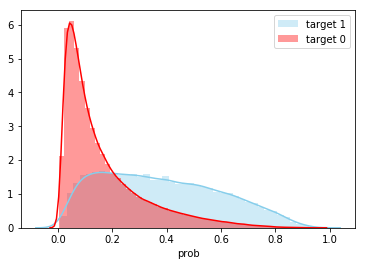

In [27]:
prob_df = pd.DataFrame({'SK_ID_CURR': data['SK_ID_CURR'], 'prob': oof_preds, 'target': data['TARGET']})
sns.distplot(prob_df['prob'].loc[prob_df.target==1] , color="skyblue", label="target 1")
sns.distplot(prob_df['prob'].loc[prob_df.target==0] , color="red", label="target 0")
plt.legend()
prob_df.to_csv('train_pred_lgb1.csv',index=False)

test['TARGET'] = sub_preds
test[['SK_ID_CURR', 'TARGET']].to_csv('test_pred_lgb1.csv', index=False, float_format='%.8f')

## Plot feature importance and auc curve

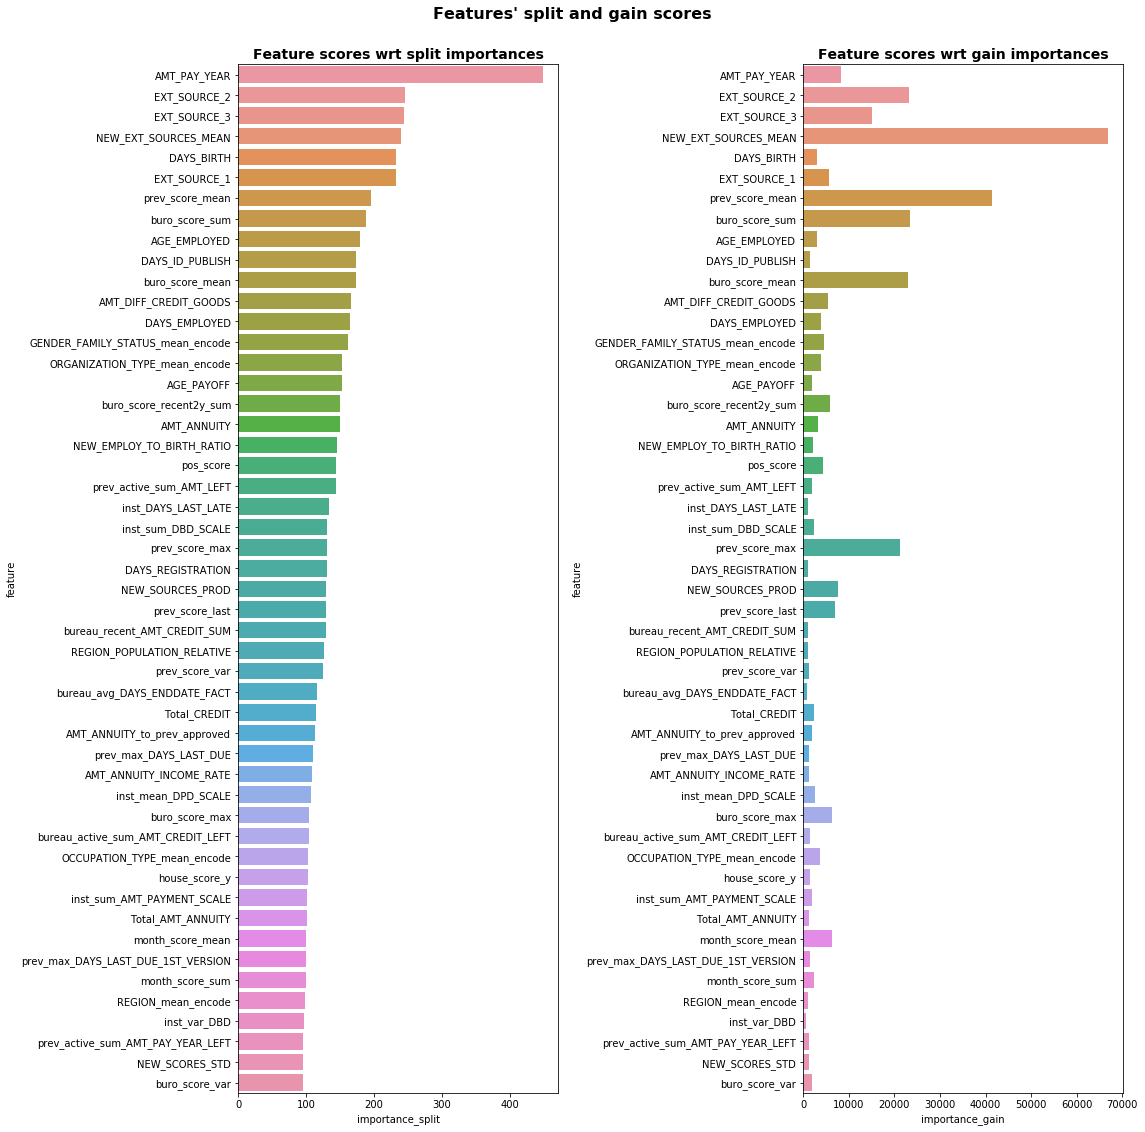

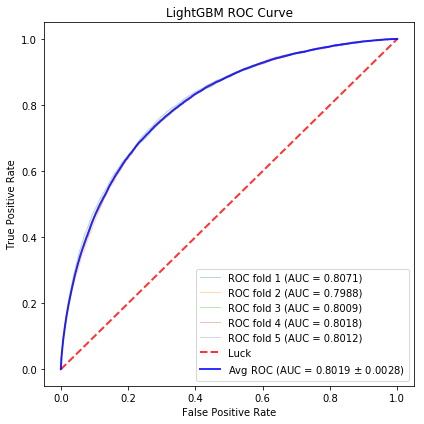

In [28]:
# Plot feature importances
feature_importance = feature_importance_df[["feature", "importance_gain", "importance_split"]].groupby("feature").mean().sort_values(
    by="importance_split", ascending=False)
feature_importance.to_csv('lgb1_feature_importance.csv')

best_features = feature_importance.iloc[:50].reset_index()

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='importance_split', y='feature', data=best_features, ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='importance_gain', y='feature', data=best_features, ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

# Plot ROC curves
plt.figure(figsize=(6,6))
scores = [] 
for n_fold, (_, val_idx) in enumerate(folds.split(data, data['TARGET'])):  
    # Plot the roc curve
    fpr, tpr, thresholds = roc_curve(y.iloc[val_idx], oof_preds[val_idx])
    score = roc_auc_score(y.iloc[val_idx], oof_preds[val_idx])
    scores.append(score)
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (n_fold + 1, score))

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Luck', alpha=.8)
fpr, tpr, thresholds = roc_curve(y, oof_preds)
score = roc_auc_score(y, oof_preds)
plt.plot(fpr, tpr, color='b',
         label='Avg ROC (AUC = %0.4f $\pm$ %0.4f)' % (score, np.std(scores)),
         lw=2, alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LightGBM ROC Curve')
plt.legend(loc="lower right")
plt.tight_layout()